# fixed-offset

Sweep different fixed-offset prefetchers over:
- mcf_46B
- libquantum_1210B


In [1]:
from collections import defaultdict
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import plots, tables
#%matplotlib widget

In [2]:
# Knobs
paths = {
    'degree1_fixed_offset': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_fixed_offset.csv',
    'degree1_featureless_tuned_nozeroaction': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_featureless_tuned_nozeroaction.csv',
}
offsets = list(range(1, 64)) #list(range(-63, 64))
dpi = 150

traces = [
    'libquantum_1210B',
    'delta_507252',
    'merced_467642',
]

# Plots
Fix prefetch degree to 1 for everything.

In [3]:
def plot_fixed_offsets(offsets_df, trace, metrics, dpi=None, figsize=None, lines={}, stack='overlap', 
                       title='', baselines={}, ymin=None, ymax=None):
    """Plot the fixed offset results."""
    X = set()
    y = np.zeros((len(metrics), len(offsets)), dtype=np.float64)
    for i, metric in enumerate(metrics):
        for j, (offset, df) in enumerate(offsets_df.items()):
            X.add(offset)
            df = df[df.cpu0_full_trace == trace]
            val = df[metric]
            val = val.item() if len(val) == 1 else np.nan
            y[i, j] = val
    
    # Plot bars
    X = np.array(sorted(list(X)))
    y = np.array(y)
    bottom = np.zeros(len(X))

    fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
    for i, metric in enumerate(metrics):
        color = 'C3' if len(metrics) == 1 else f'C{i}'
        ax.bar(X, y[i], color=color, bottom=bottom, label=metric, zorder=len(metrics)-i)
        if stack == 'sum':
            bottom += np.nan_to_num(y[i,:])
    
    # Plot lines, based on first stat
    bl_colors = {
        'cygnus': 'C1',
        'bo': 'C2',
        'bfo': 'C4'
    }
    for i, (bl, bldf) in enumerate(baselines.items()):
        bdf = bldf[bldf.cpu0_full_trace == trace]
        val = bdf[metric]
        val = val.iloc[0].item() if len(val) > 0 else np.nan #if len(val) == 1 else np.nan
        ax.axhline(val, linestyle='--', label=bl, color=bl_colors[bl])
            
    ax.set_axisbelow(True)
    ax.grid()   
    ax.set_xlim(0, 64)# -64, 64)
    ax.set_ylim(ymin, ymax)
    ax.set_xticks(np.arange(0, 65, 4)) #(-64, 65, 4))

    ax.set_xlabel('Fixed offset')
    ax.set_ylabel(title)
    fig.suptitle(f'{trace} {title}')
    fig.legend()
    plt.show()

In [4]:
reload(tables)
dfs = tables.load_stats_csv_next_line(paths['degree1_fixed_offset'], offsets=offsets)
baselines = {
    'bfo': tables.load_stats_csv_next_line(paths['degree1_fixed_offset'], offsets=['best'])['best'],
    'cygnus': tables.load_stats_csv(paths['degree1_featureless_tuned_nozeroaction'], prefetchers=['cygnus'])['cygnus'],
    'bo': tables.load_stats_csv(paths['degree1_featureless_tuned_nozeroaction'], prefetchers=['bo'])['bo'],
}

## CPU
### IPC improvement

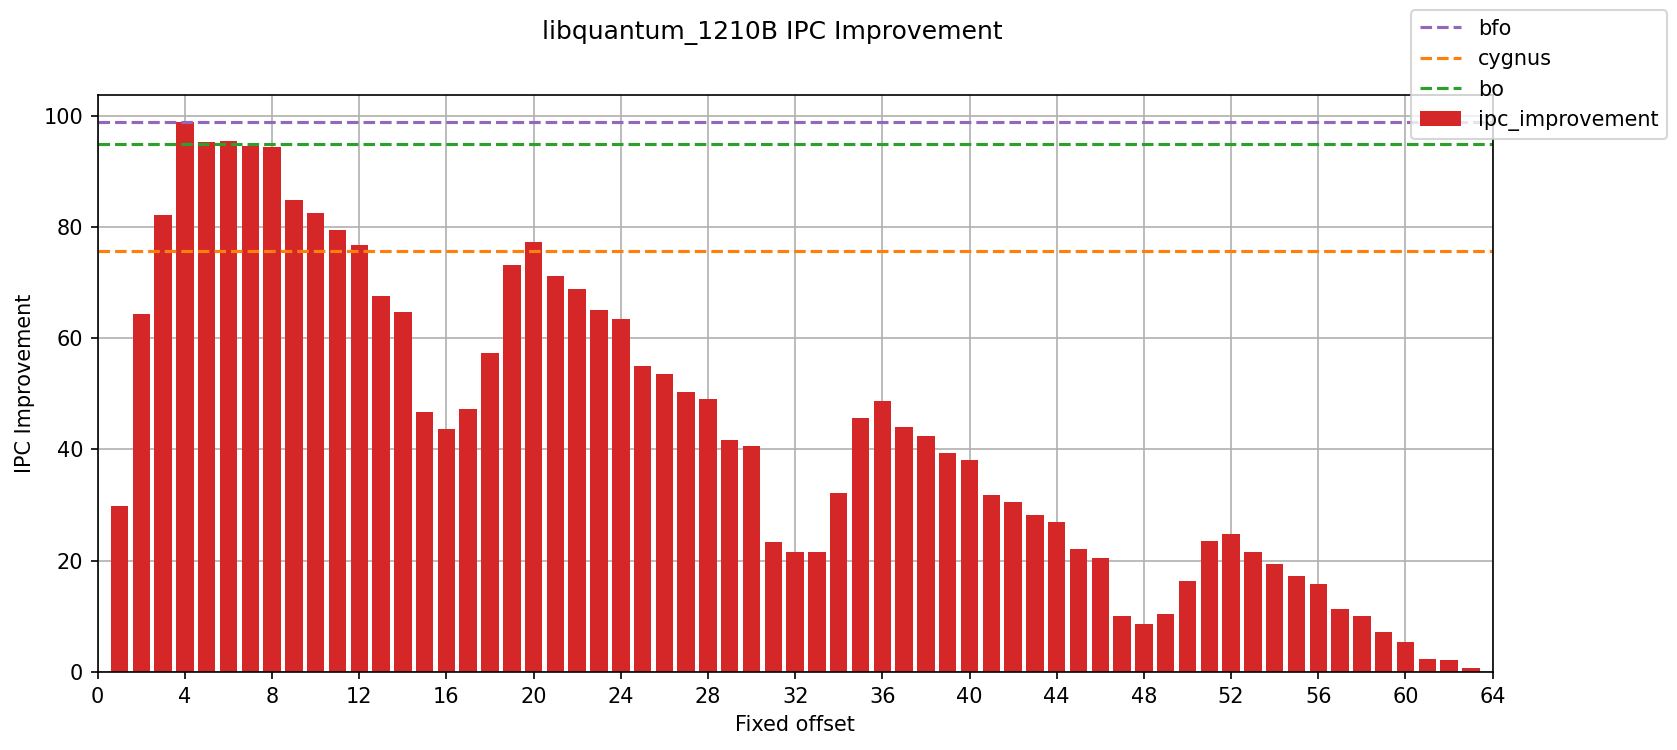

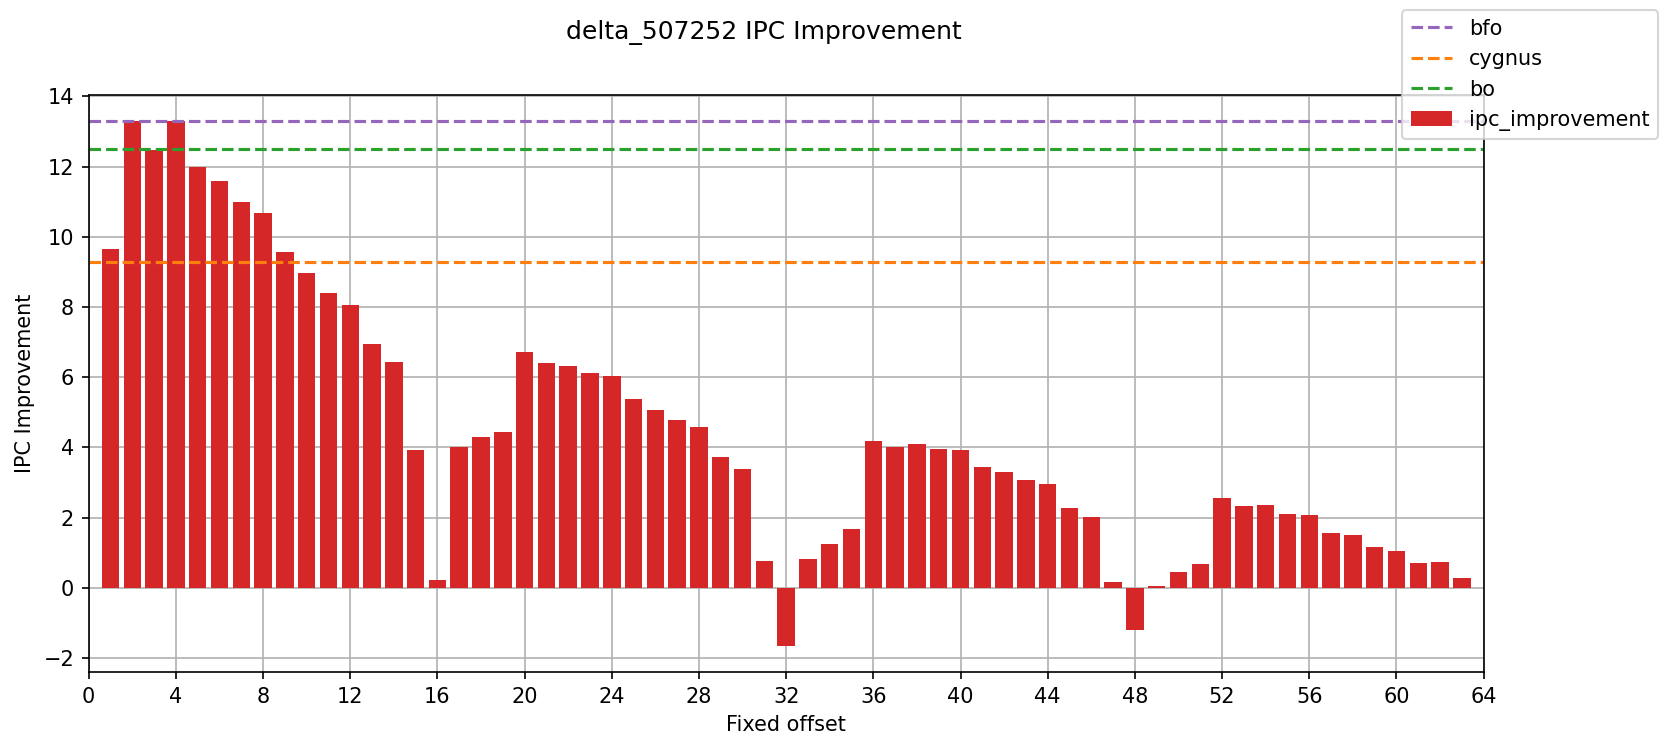

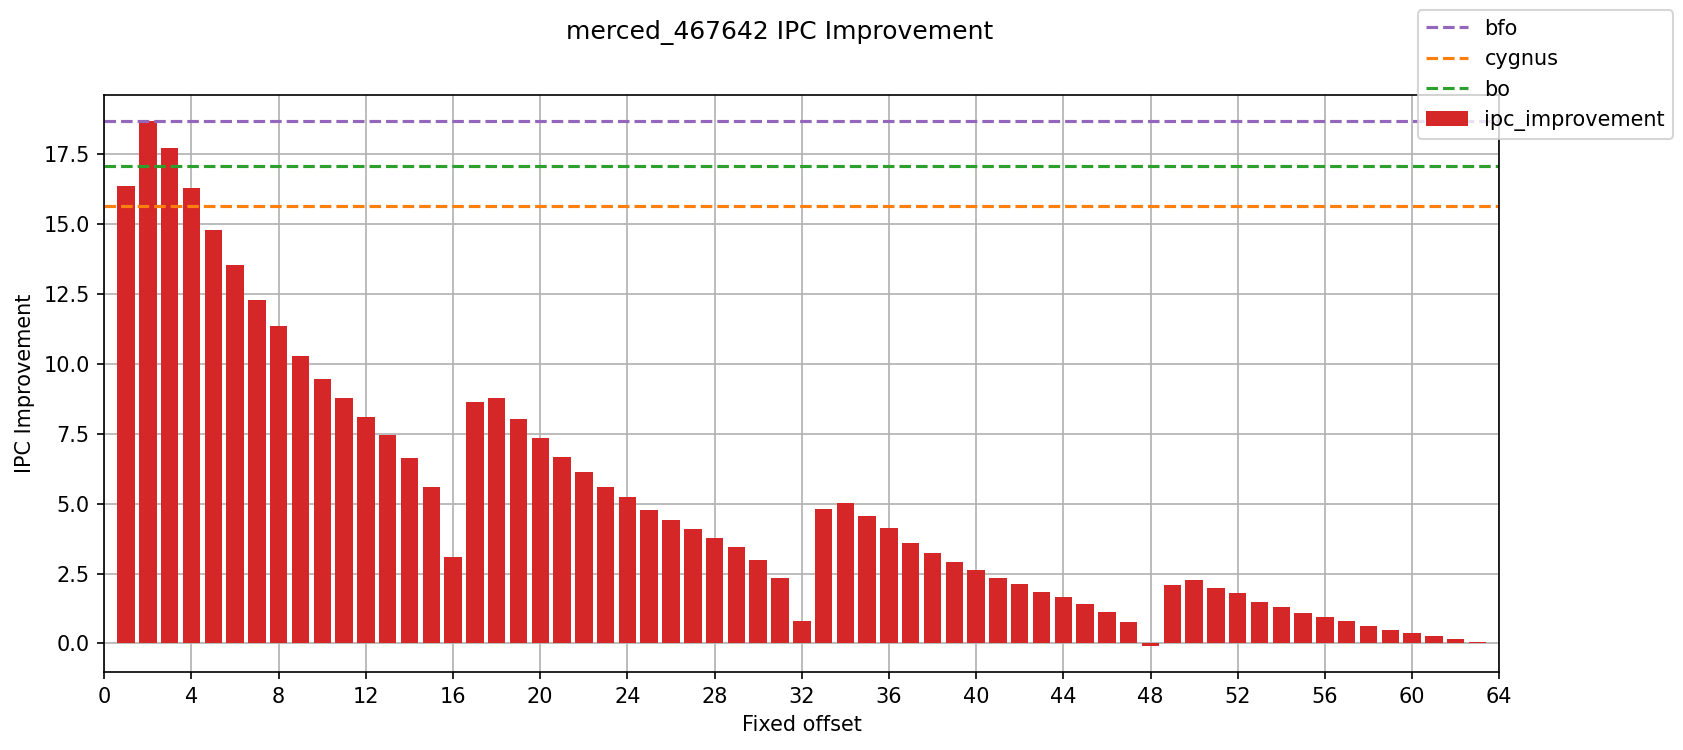

In [5]:
for trace in traces:
    plot_fixed_offsets(dfs, trace, ['ipc_improvement'], title='IPC Improvement',
                    dpi=dpi, figsize=(12, 5), baselines=baselines)

### Stalled cycles
#### Total

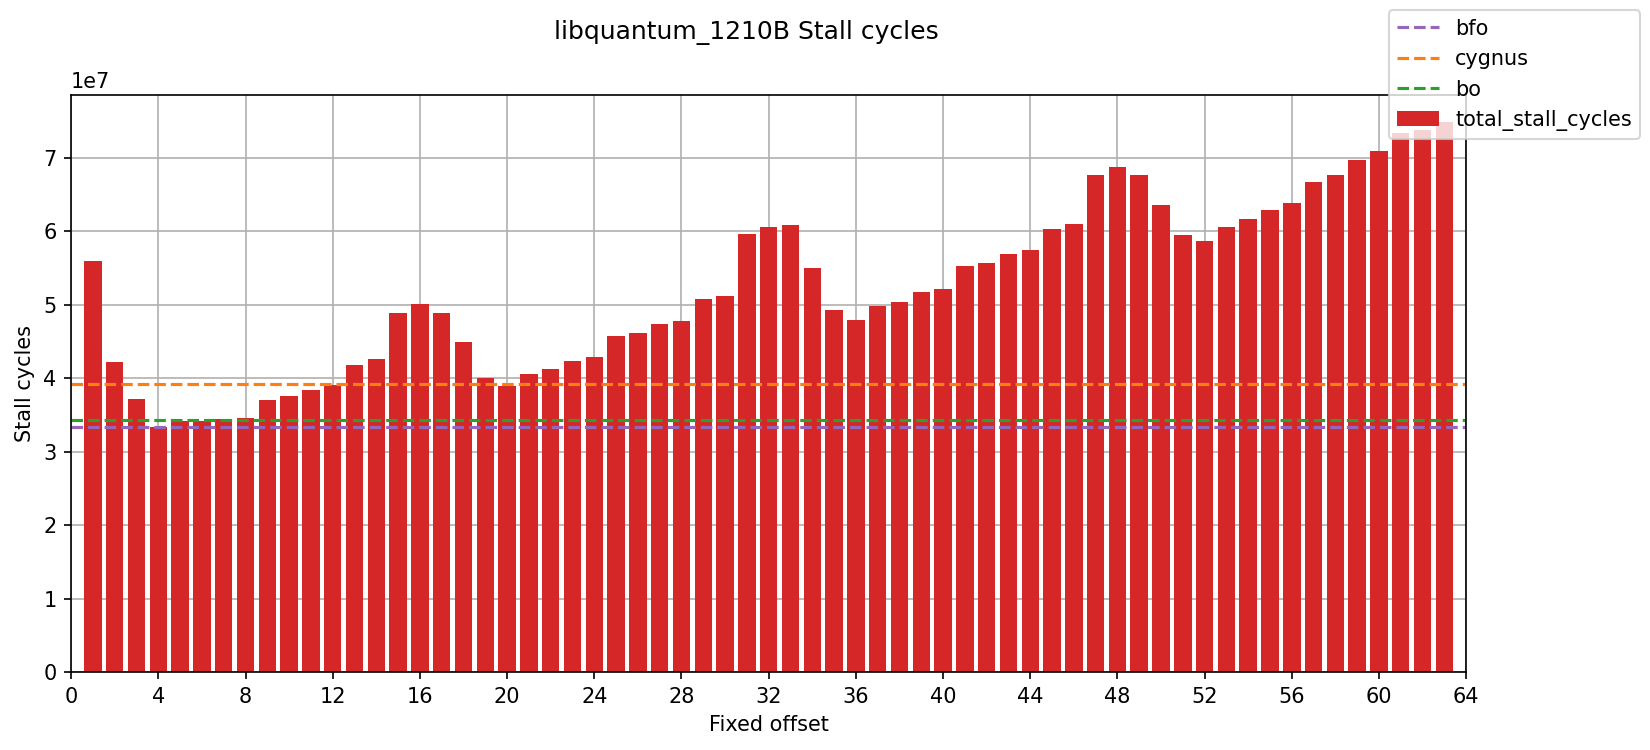

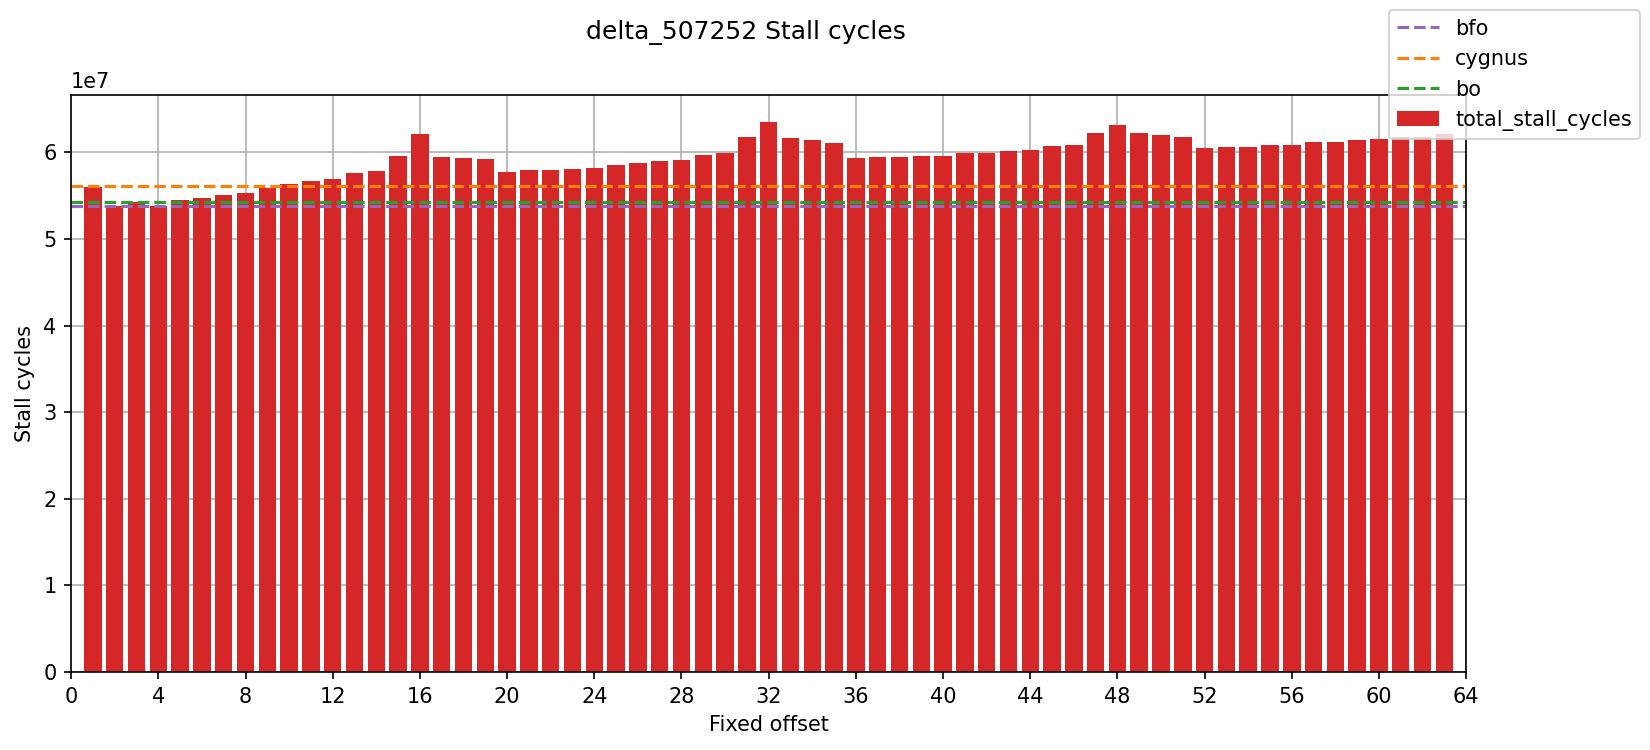

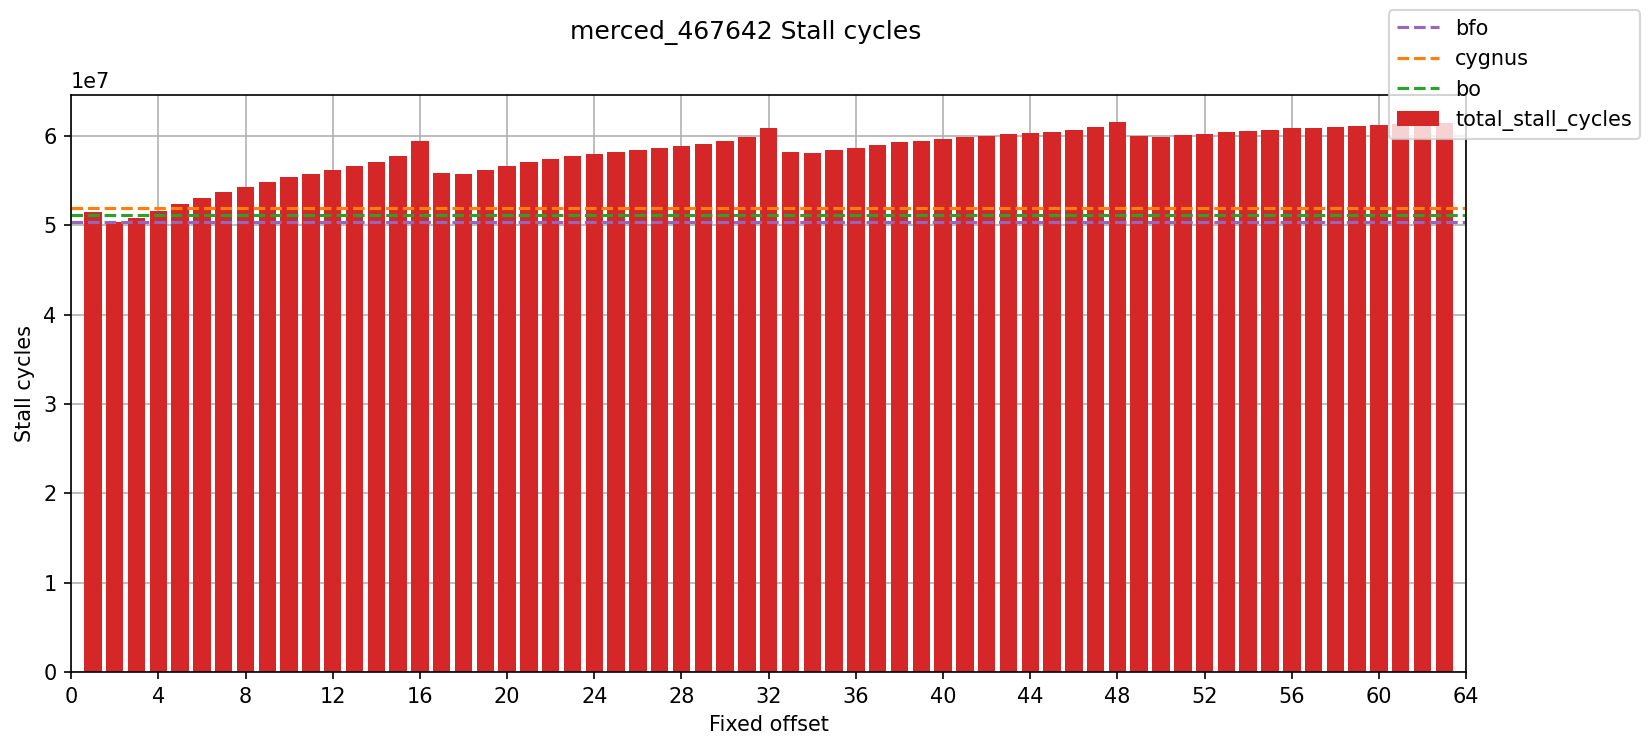

In [6]:
for trace in traces:
    plot_fixed_offsets(dfs, trace, ['total_stall_cycles'], title='Stall cycles',
                       dpi=dpi, figsize=(12, 5), baselines=baselines)

#### Memory

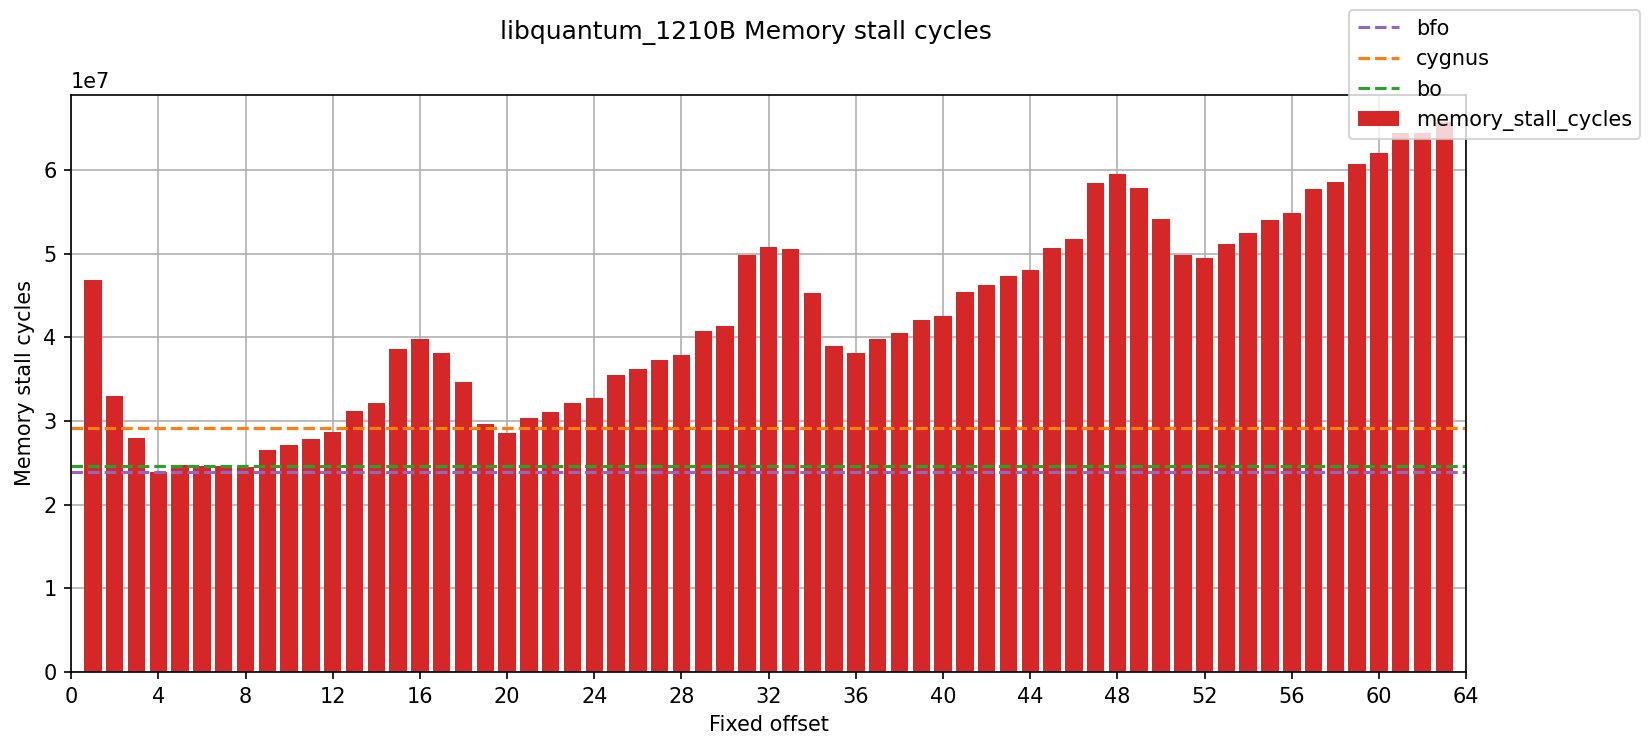

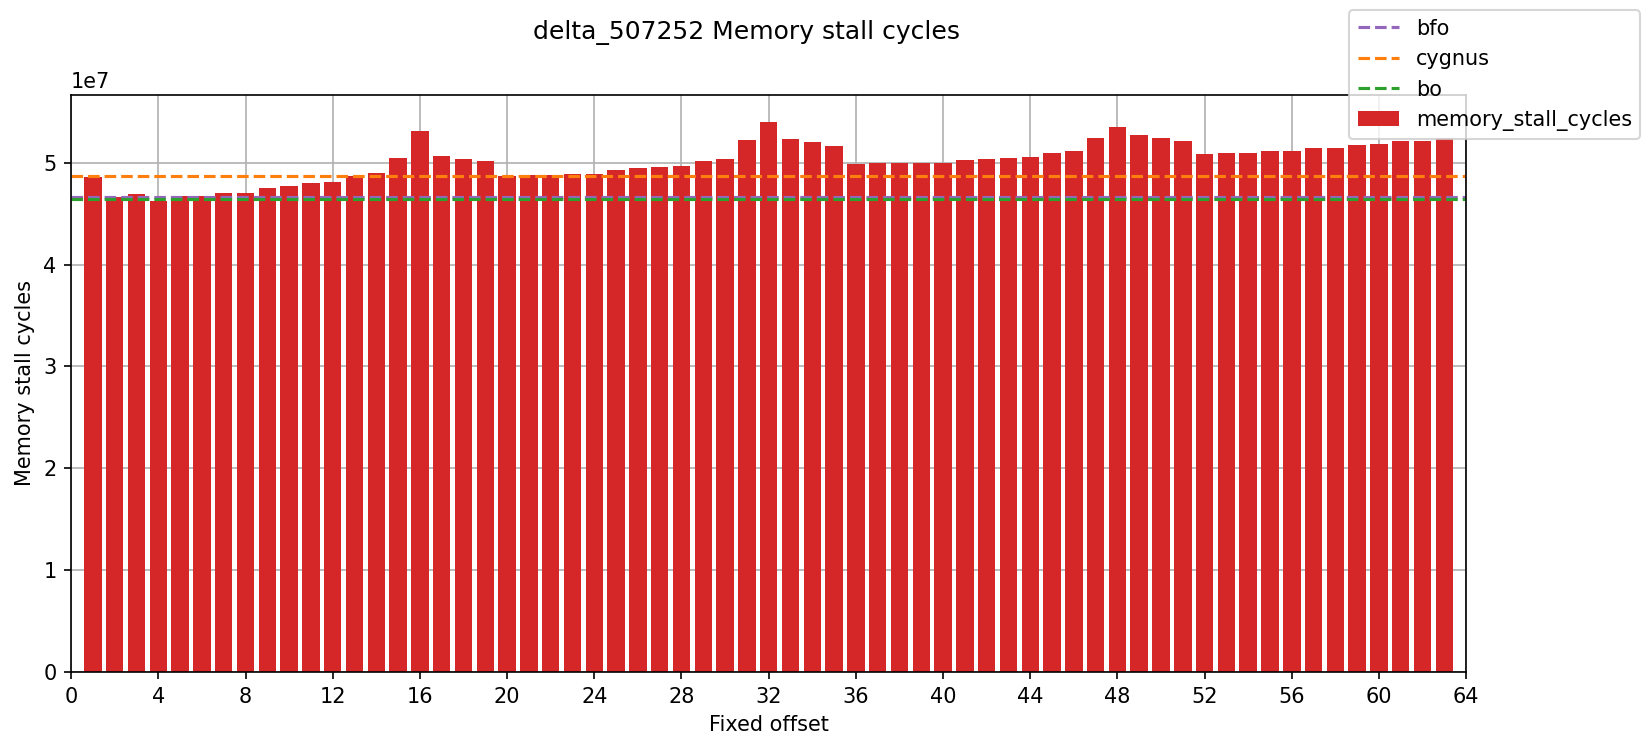

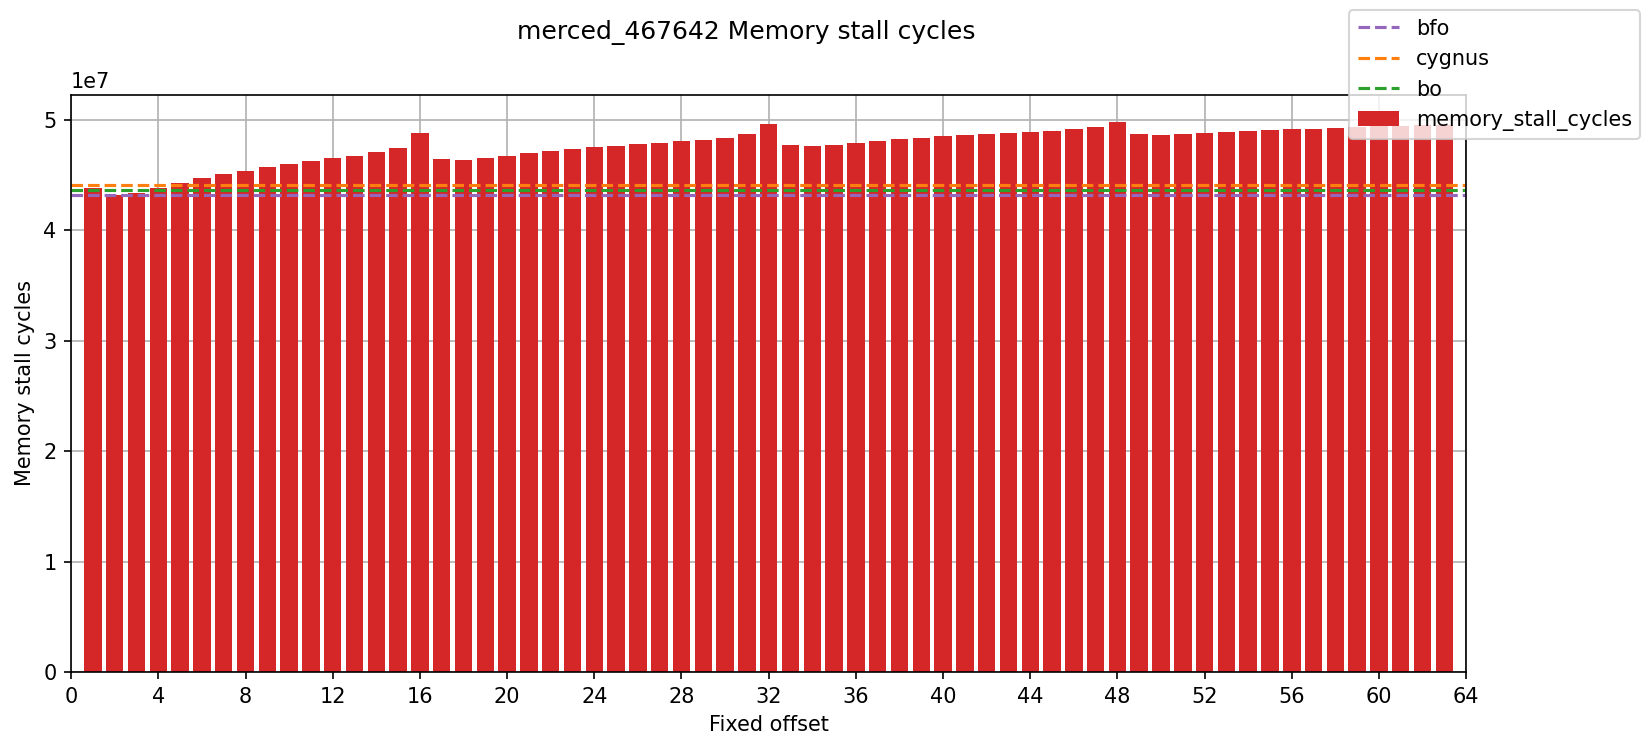

In [7]:
for trace in traces:
    plot_fixed_offsets(dfs, trace, ['memory_stall_cycles'], title='Memory stall cycles',
                       dpi=dpi, figsize=(12, 5), baselines=baselines)

### Stalled instructions
#### Total

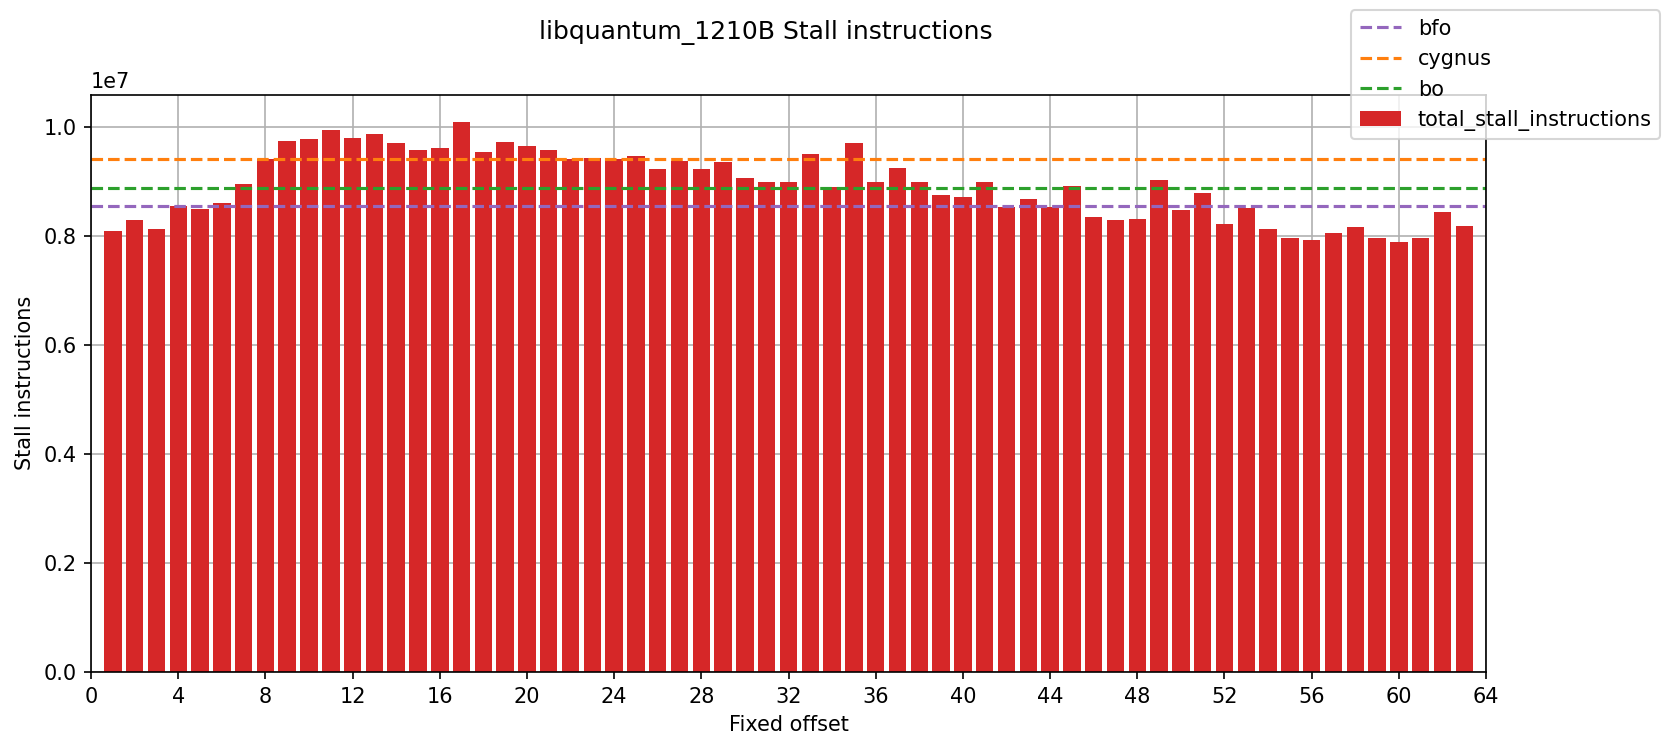

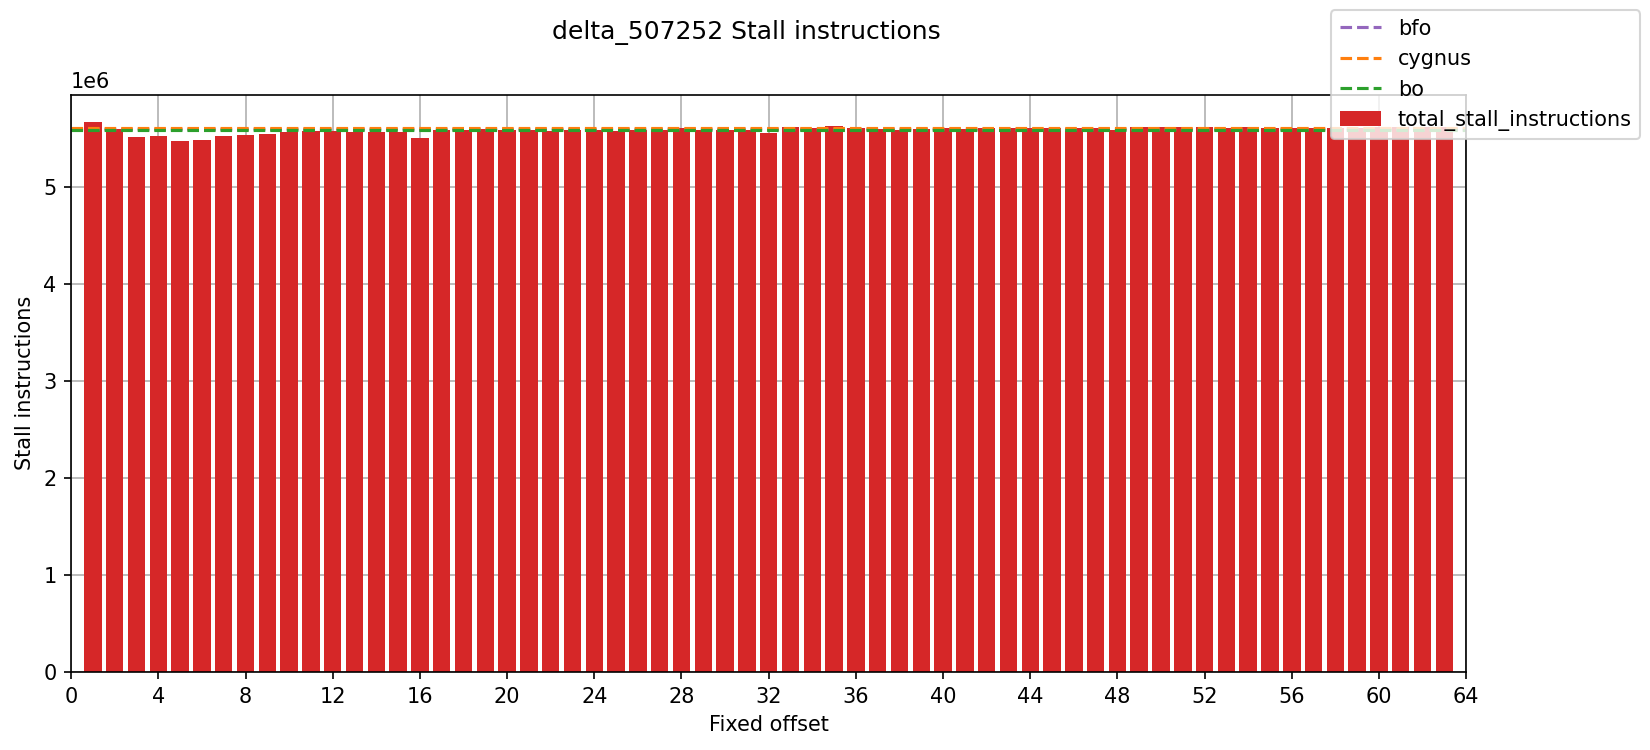

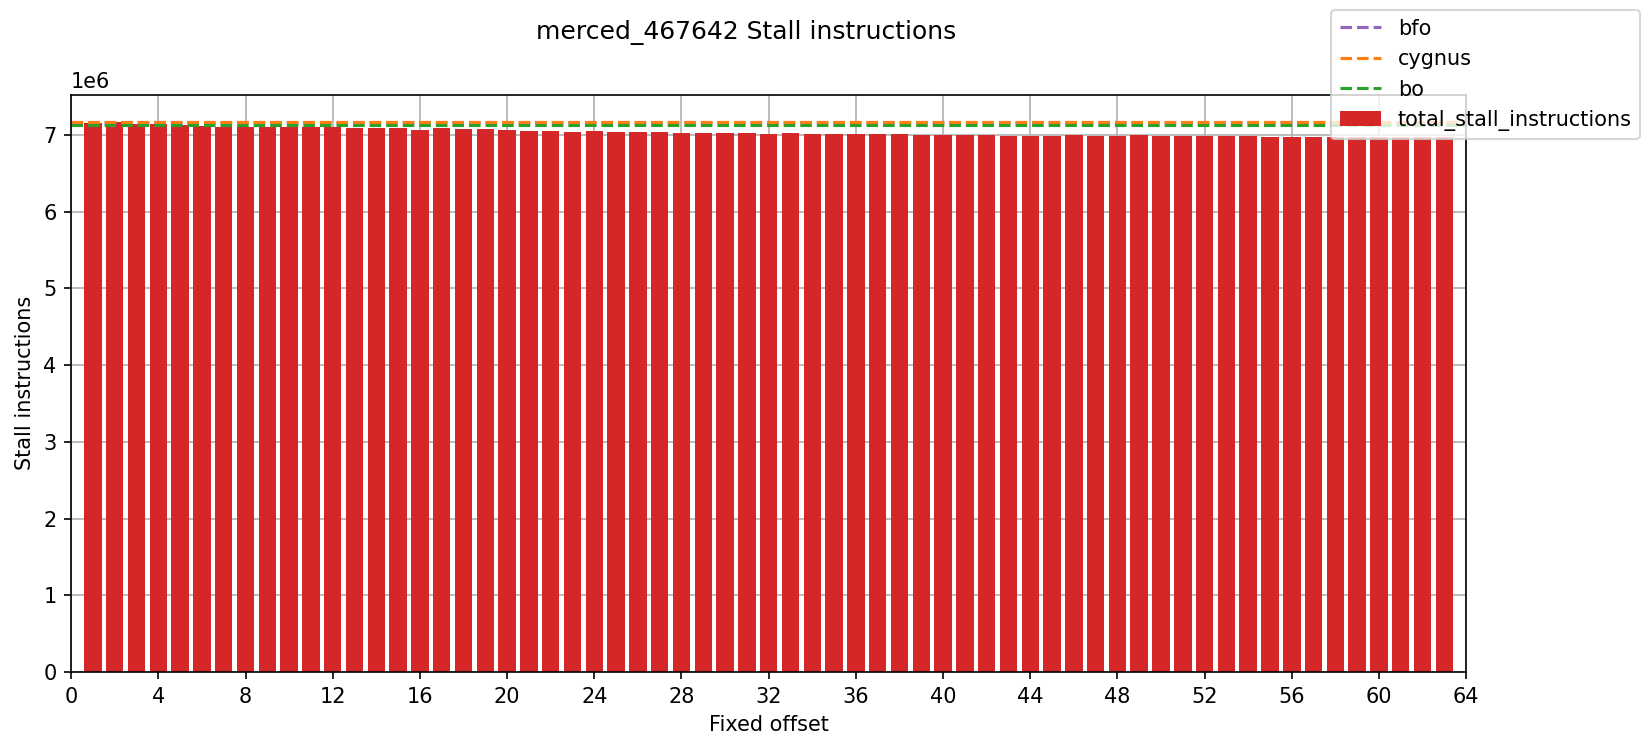

In [8]:
for trace in traces:
    plot_fixed_offsets(dfs, trace, ['total_stall_instructions'], title='Stall instructions',
                       dpi=dpi, figsize=(12, 5), baselines=baselines)

#### Memory

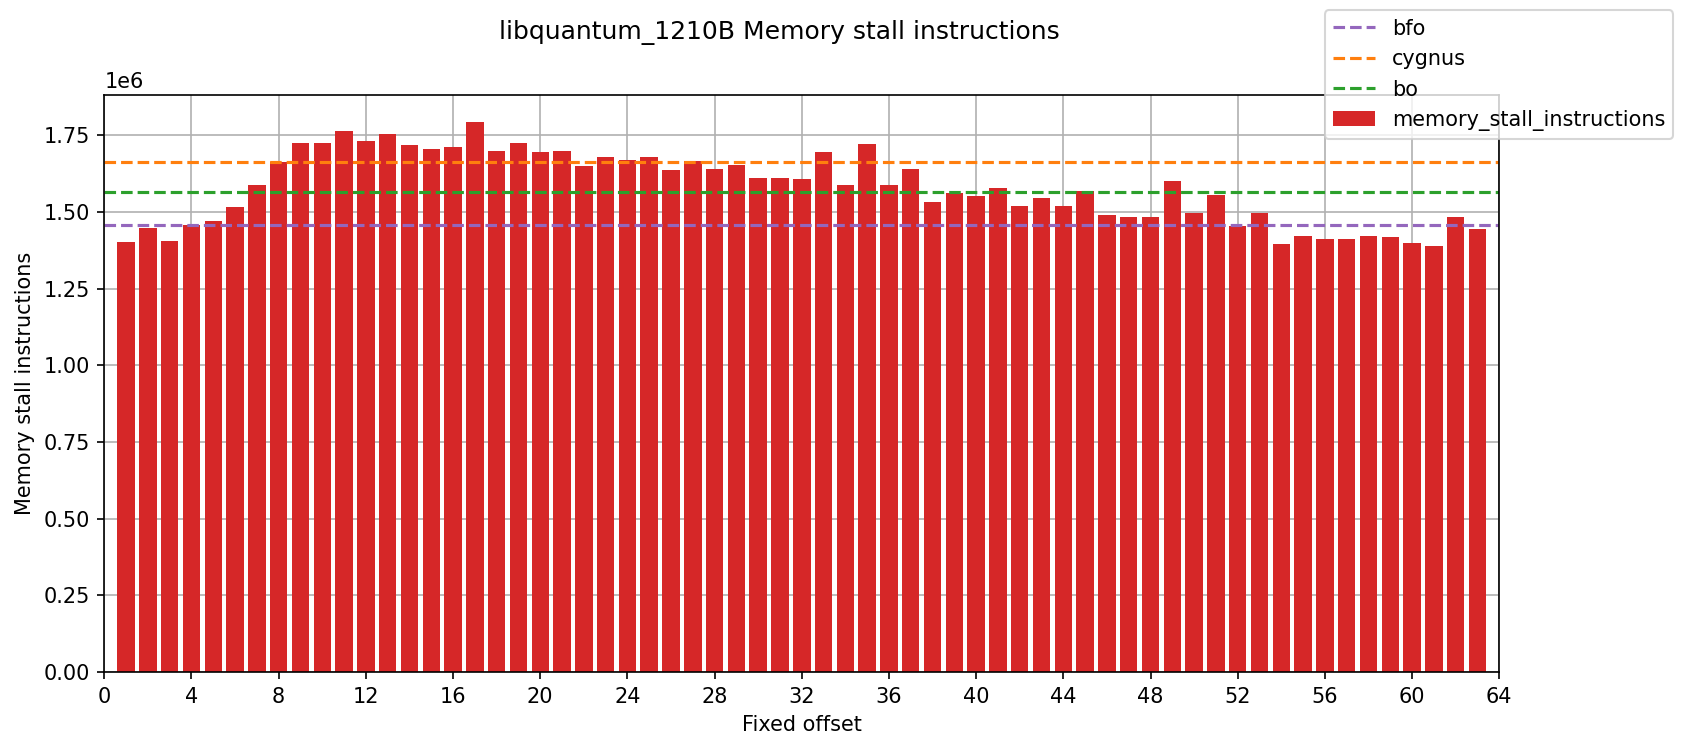

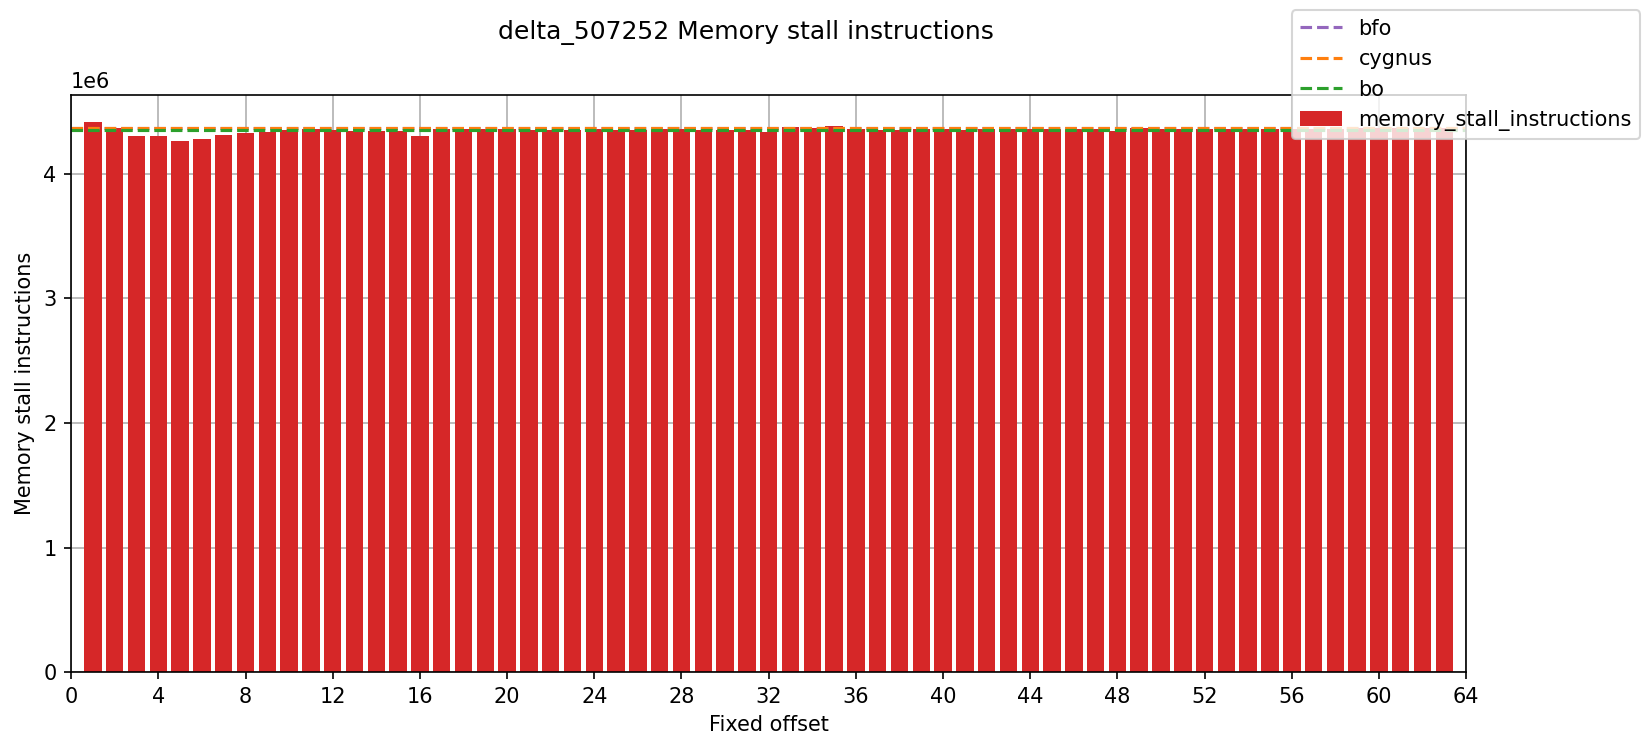

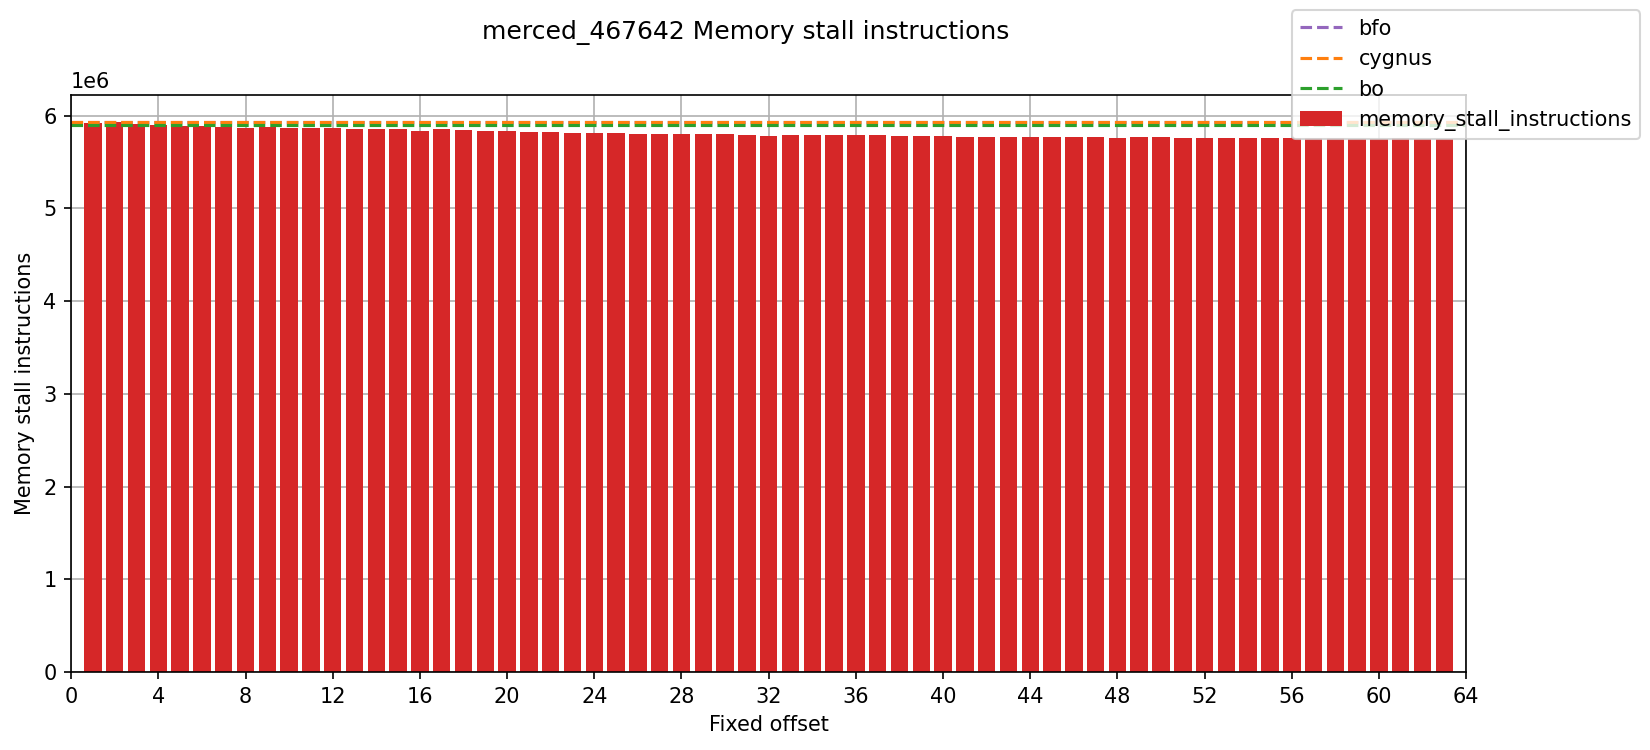

In [9]:
for trace in traces:
    plot_fixed_offsets(dfs, trace, ['memory_stall_instructions'], title='Memory stall instructions',
                       dpi=dpi, figsize=(12, 5), baselines=baselines)

### Stalled retirement slots (TODO)
#### Total

In [10]:
# for trace in traces:
#     plot_fixed_offsets(dfs, trace, ['total_stall_slots'], title='Memory stall retirement slots',
#                        dpi=dpi, figsize=(12, 5), baselines=baselines)

#### Memory

In [11]:
# for trace in traces:
#     plot_fixed_offsets(dfs, trace, ['memory_stall_slots'], title='Memory stall retirement slots',
#                        dpi=dpi, figsize=(12, 5), baselines=baselines)

## L2
### Coverage

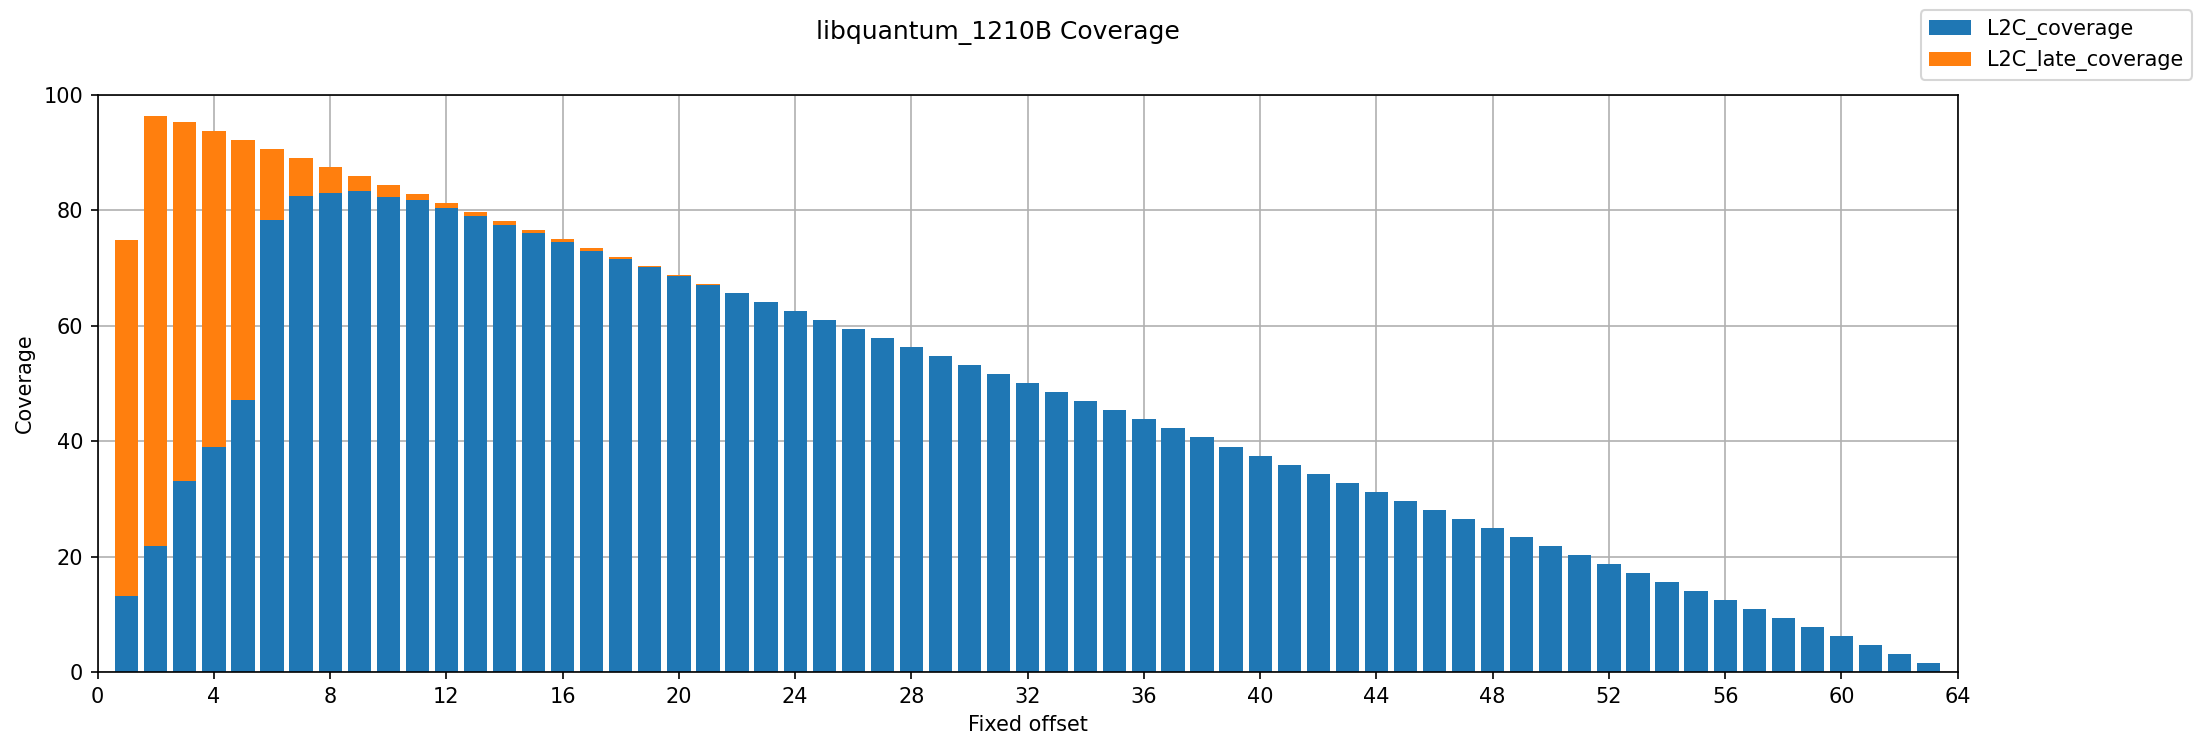

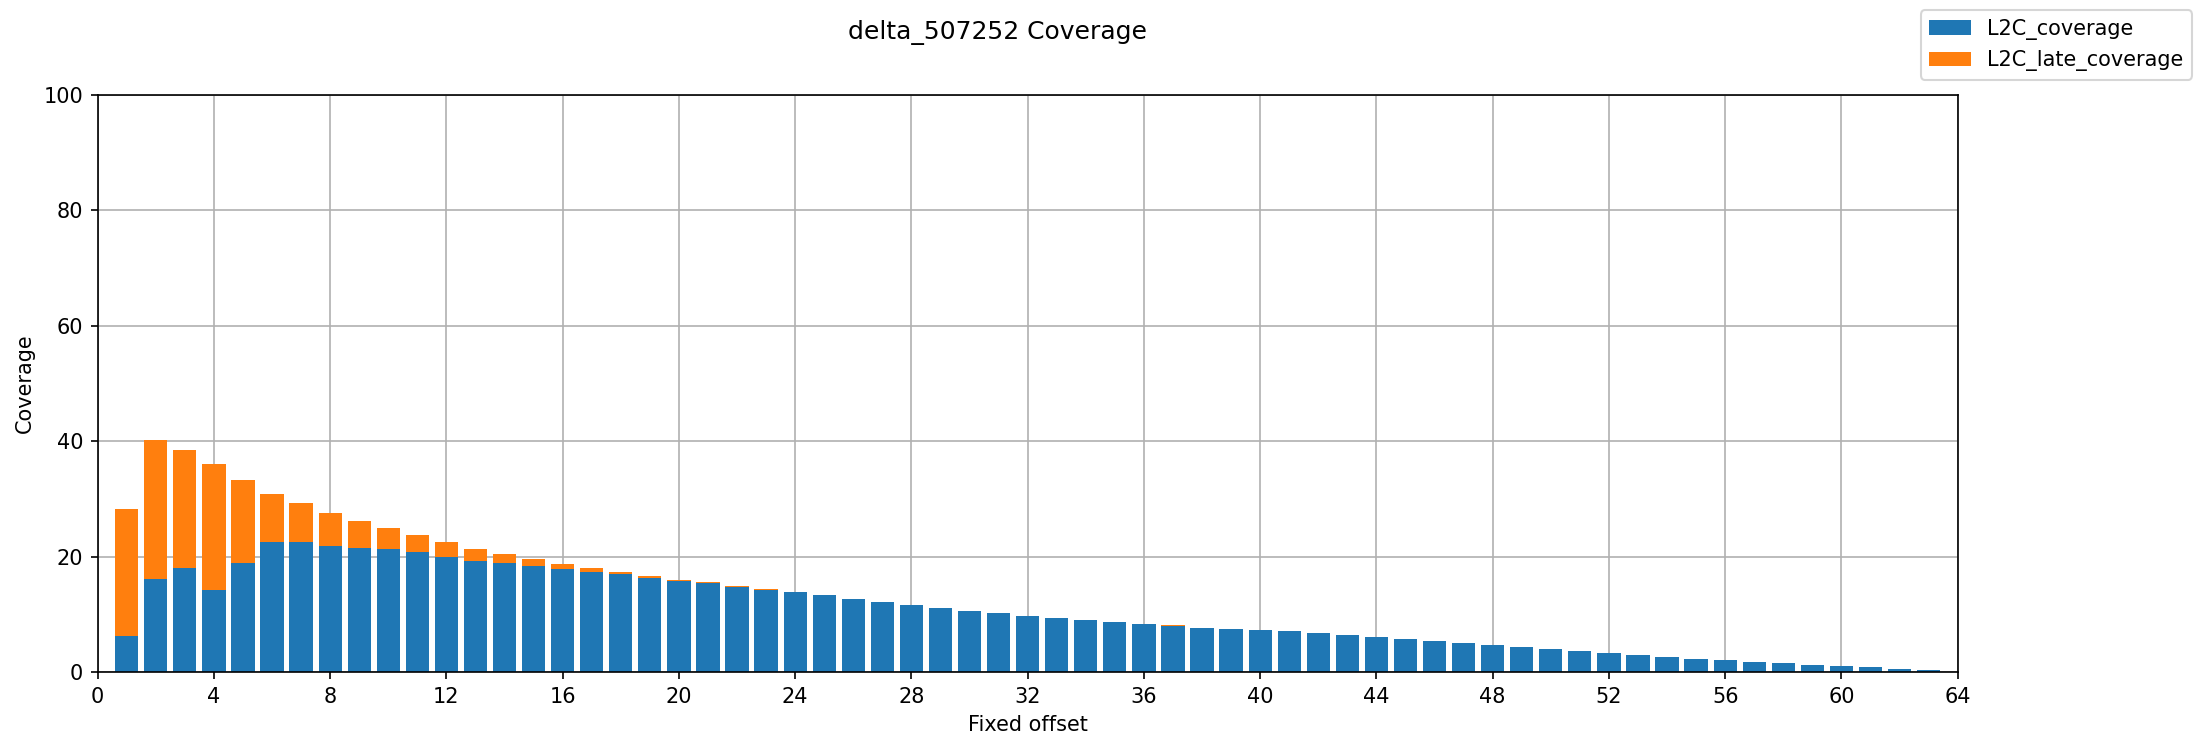

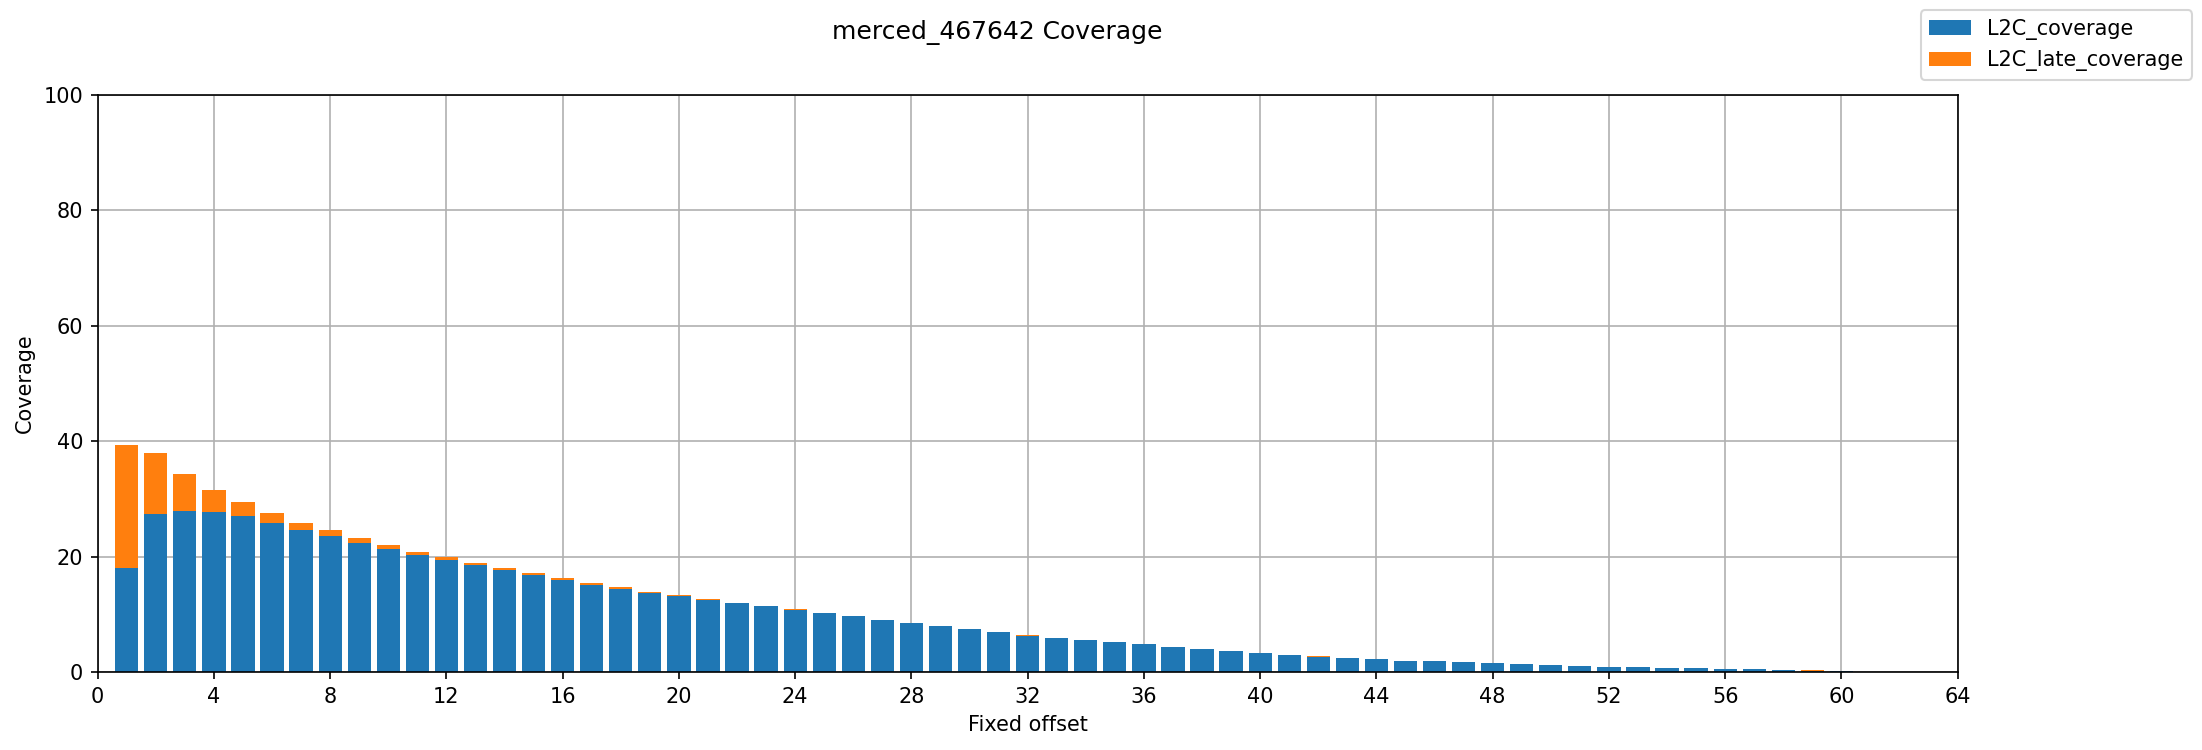

In [12]:
for trace in traces:
    plot_fixed_offsets(dfs, trace, ['L2C_coverage', 'L2C_late_coverage'], title='Coverage',
                       dpi=dpi, figsize=(16, 5), ymin=0, ymax=100, stack='overlap')

### Accuracy

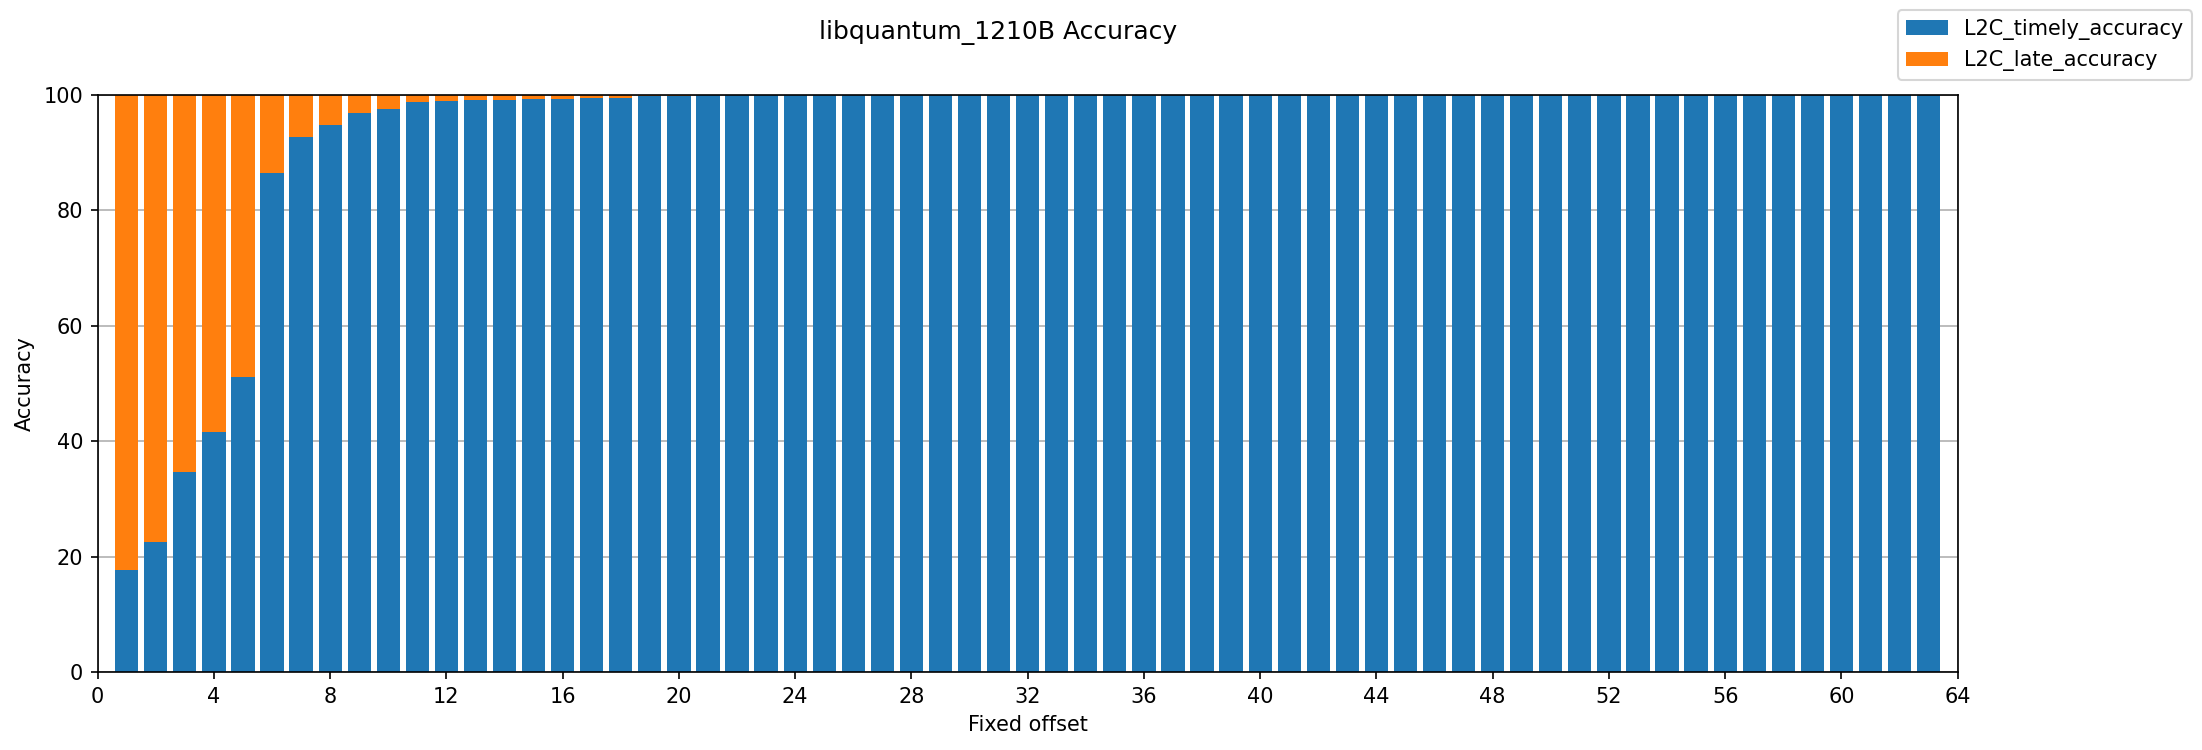

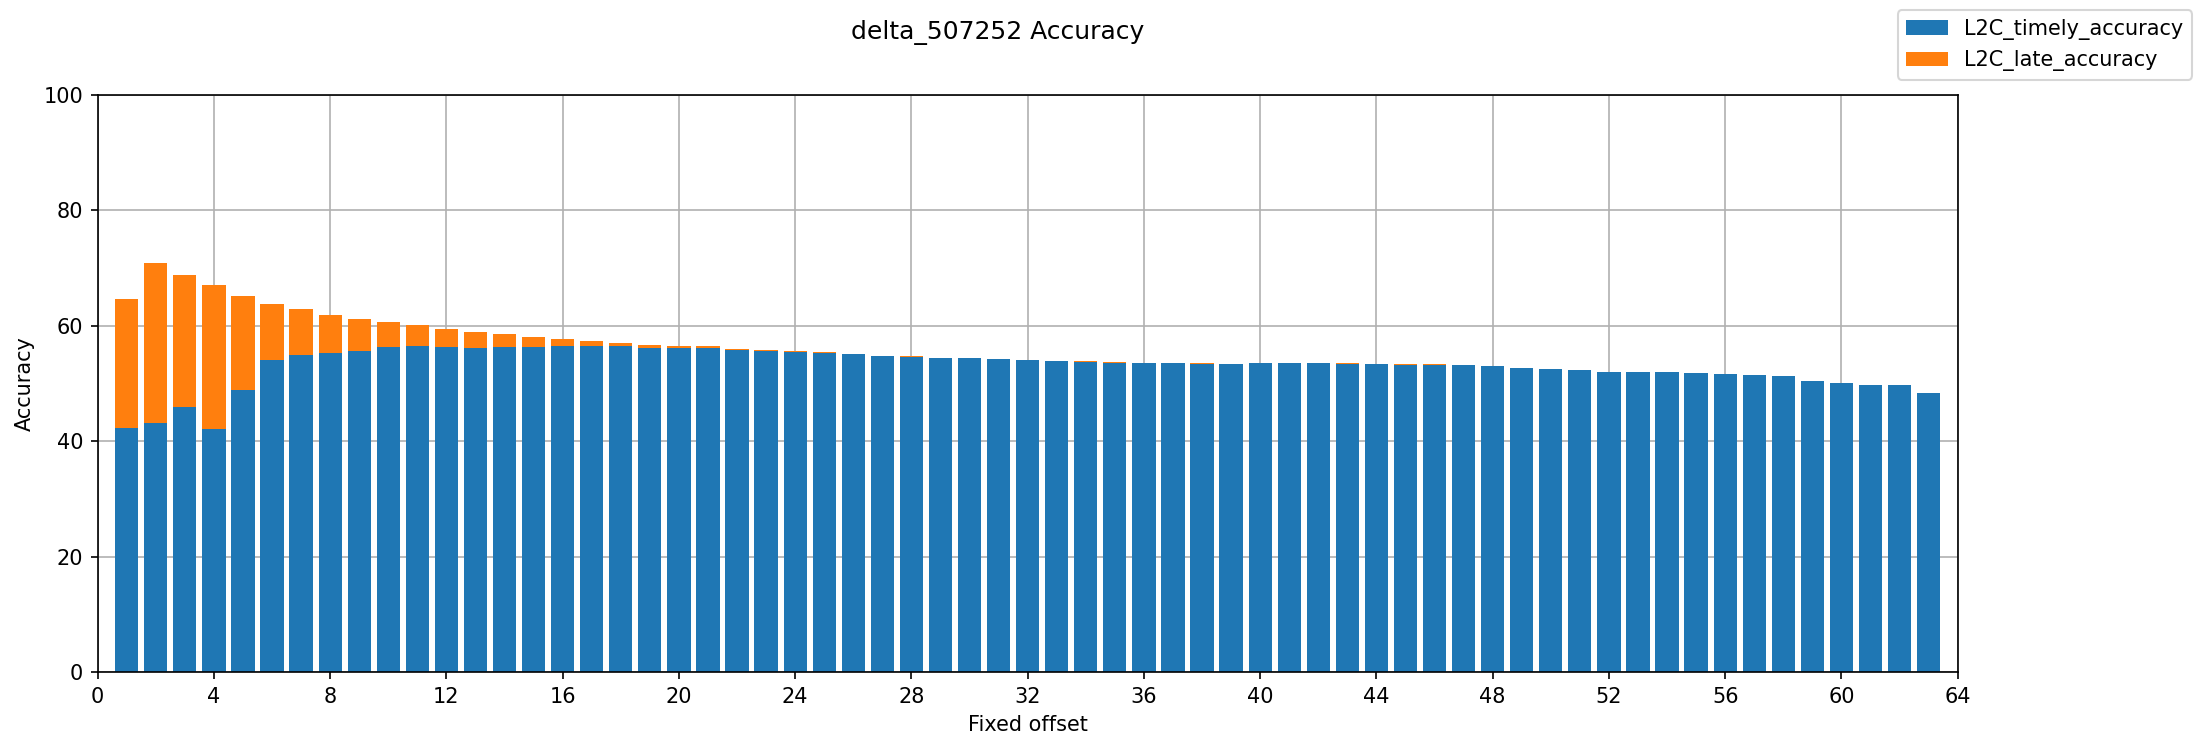

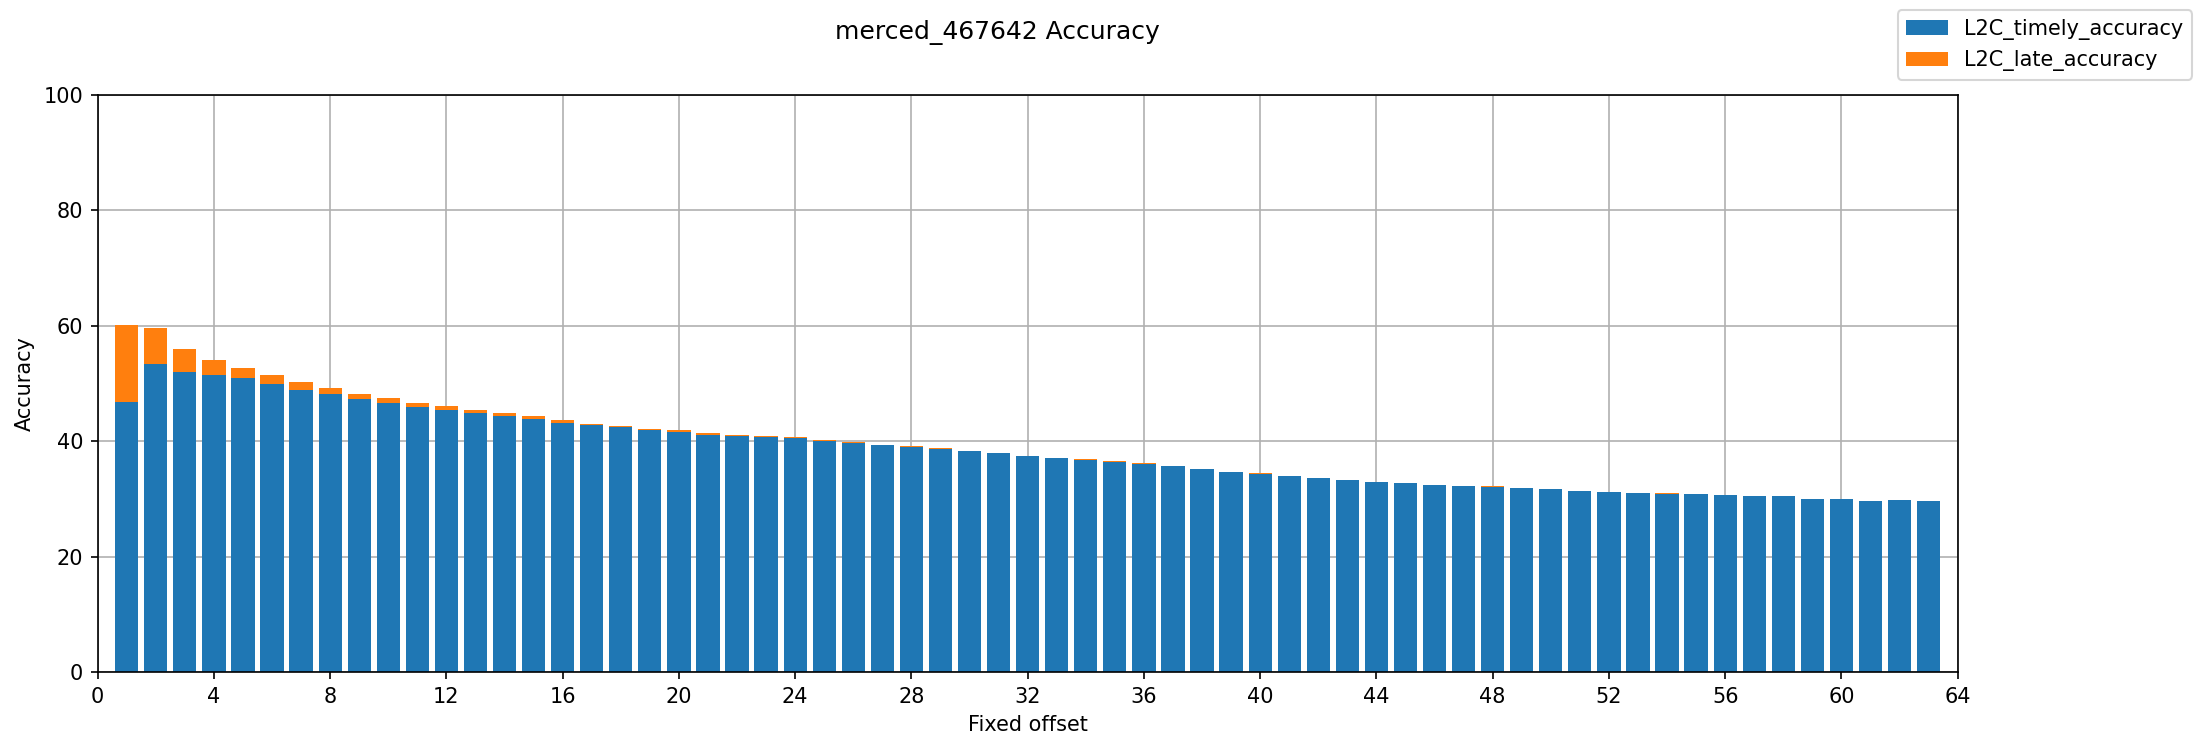

In [13]:
for trace in traces:
    plot_fixed_offsets(dfs, trace, ['L2C_timely_accuracy', 'L2C_late_accuracy'], title='Accuracy',
                       dpi=dpi, figsize=(16, 5), ymin=0, ymax=100, stack='sum')

### Hits/misses

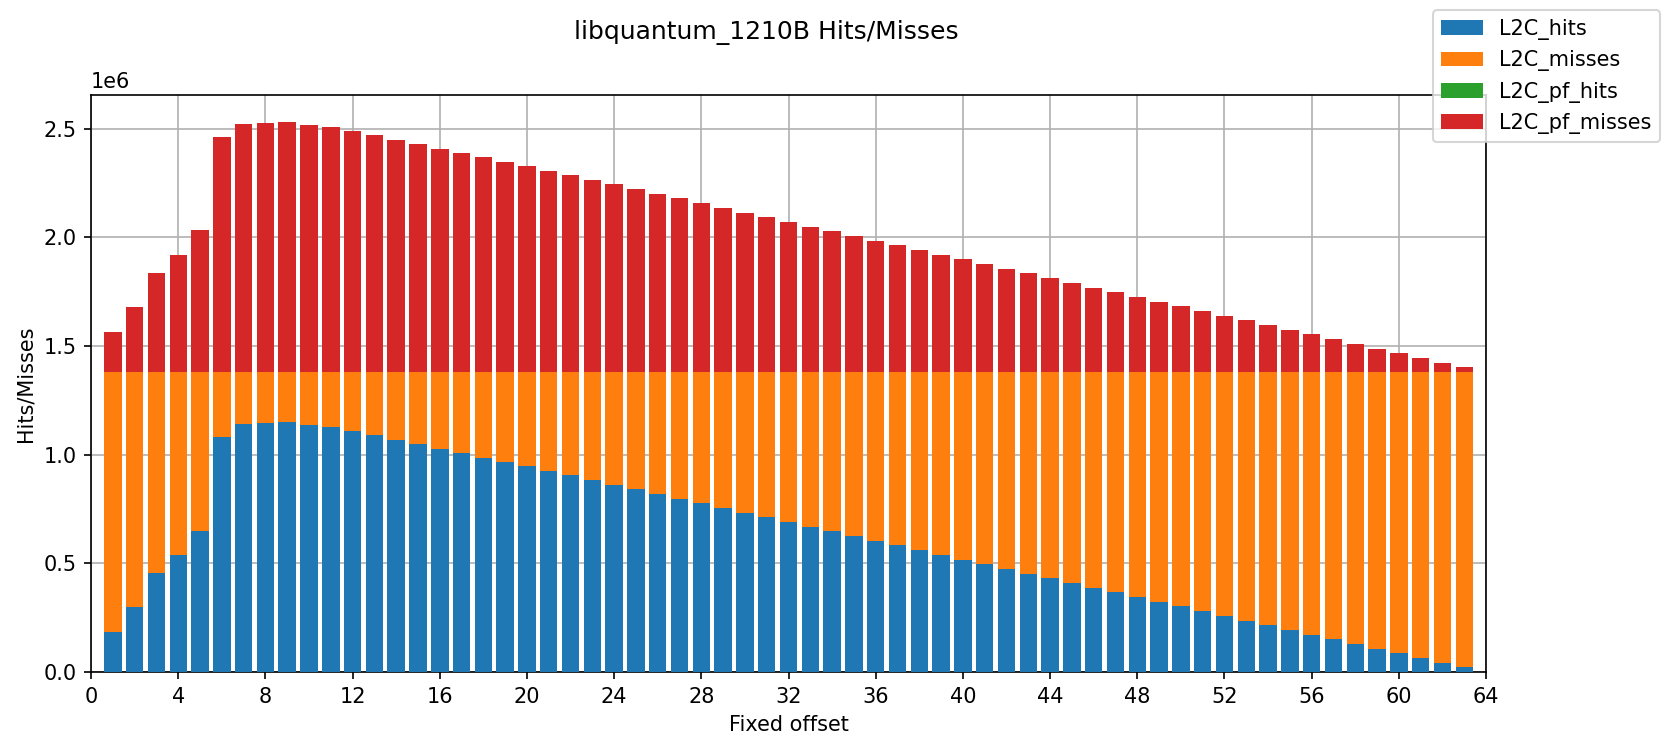

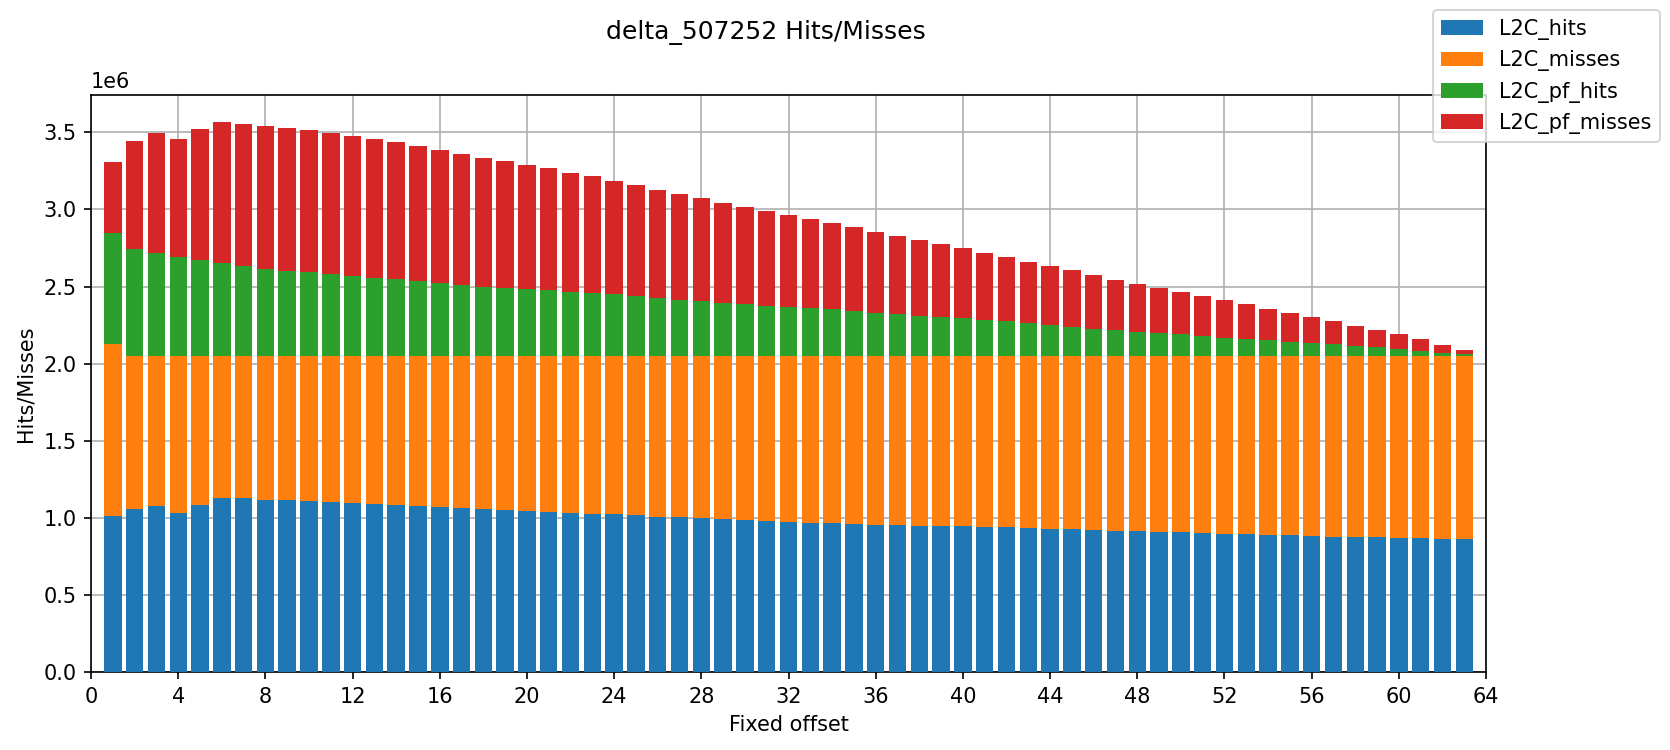

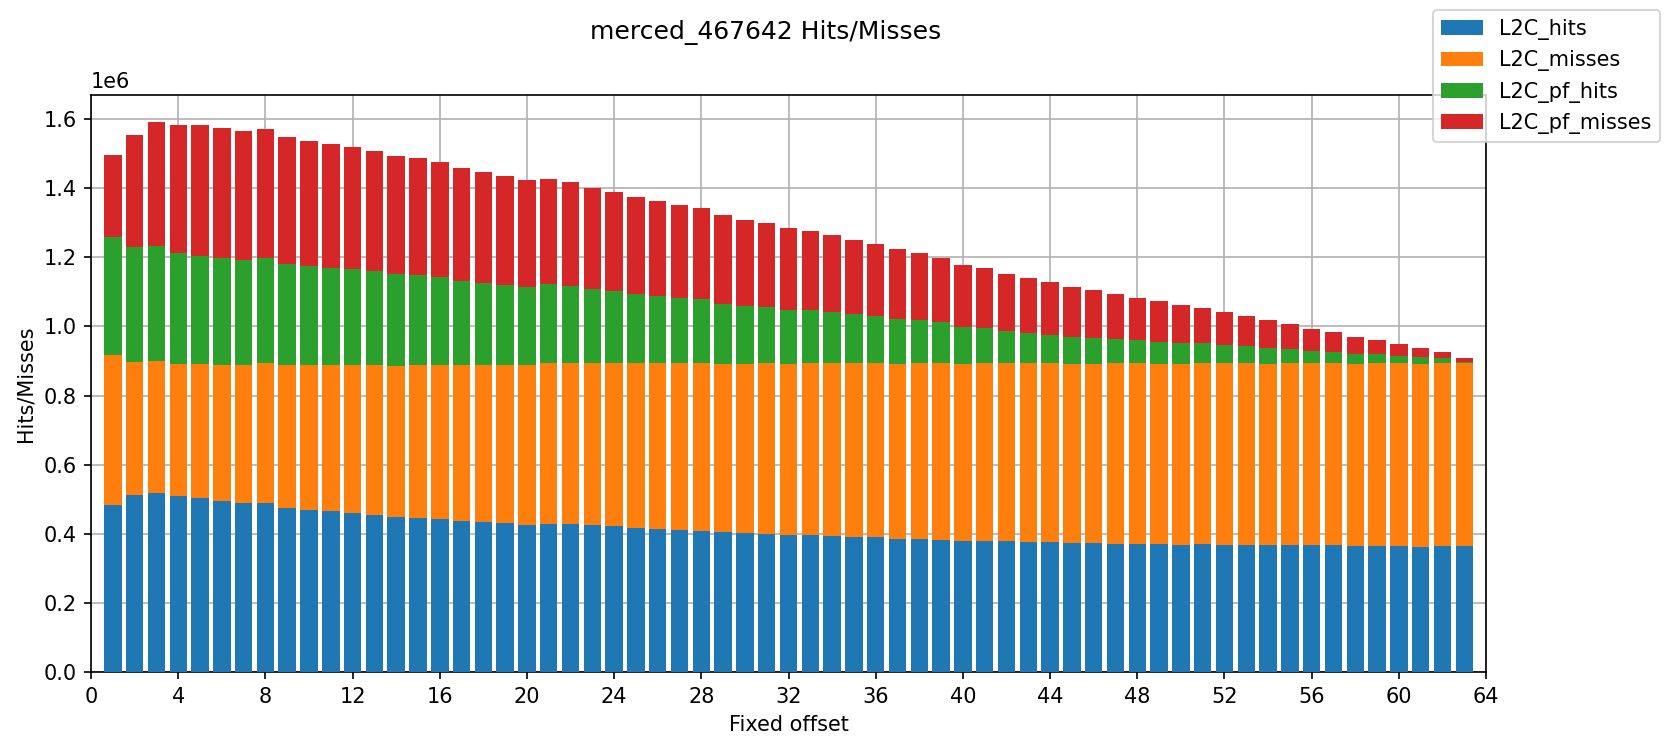

In [14]:
for trace in traces:
    plot_fixed_offsets(dfs, trace, ['L2C_hits', 'L2C_misses', 'L2C_pf_hits', 'L2C_pf_misses'],
                       title='Hits/Misses', dpi=dpi, figsize=(12, 5), stack='sum')

## L1D
### Exposed miss cycles

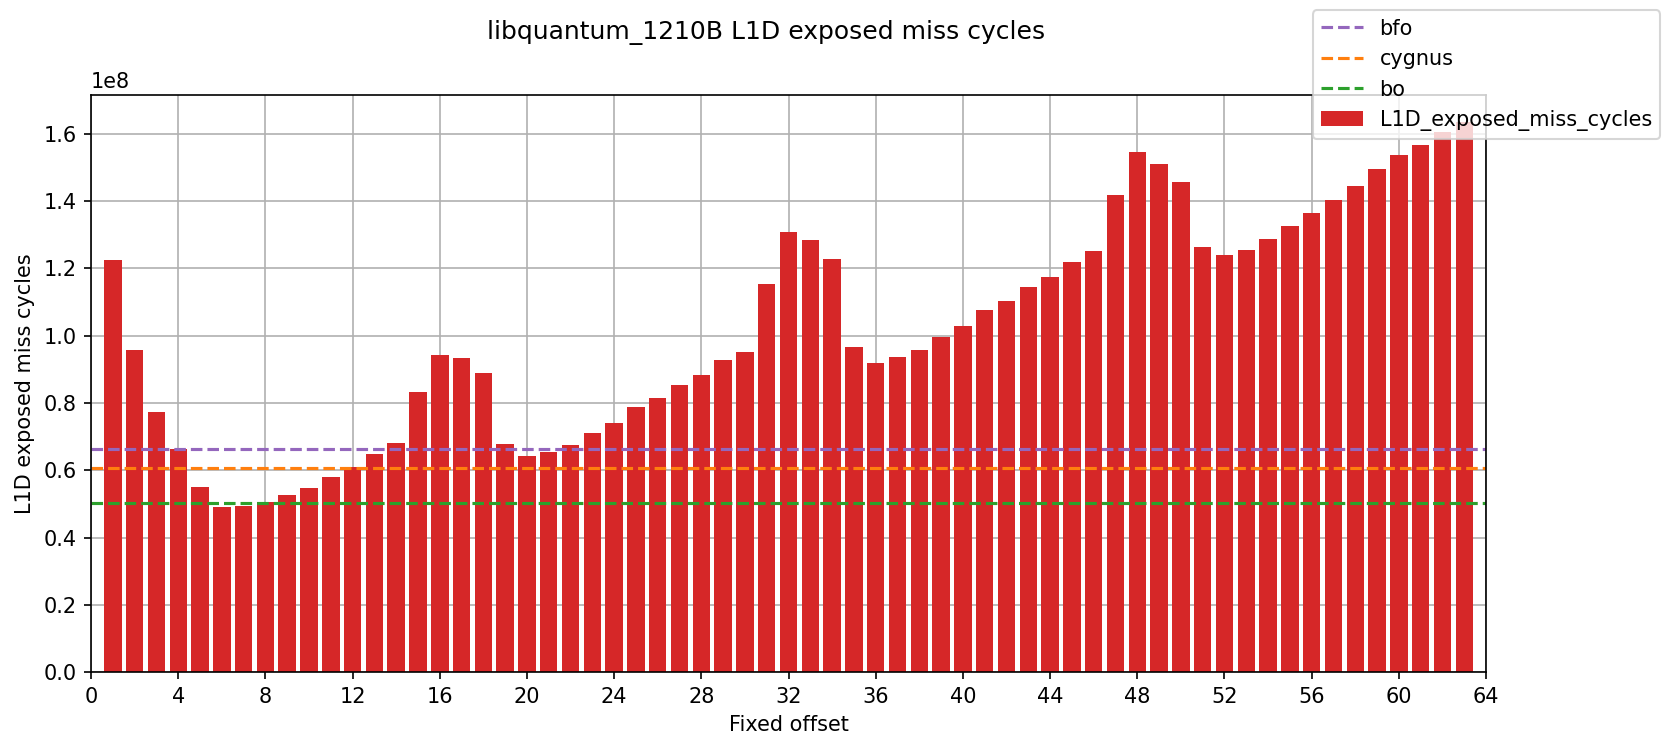

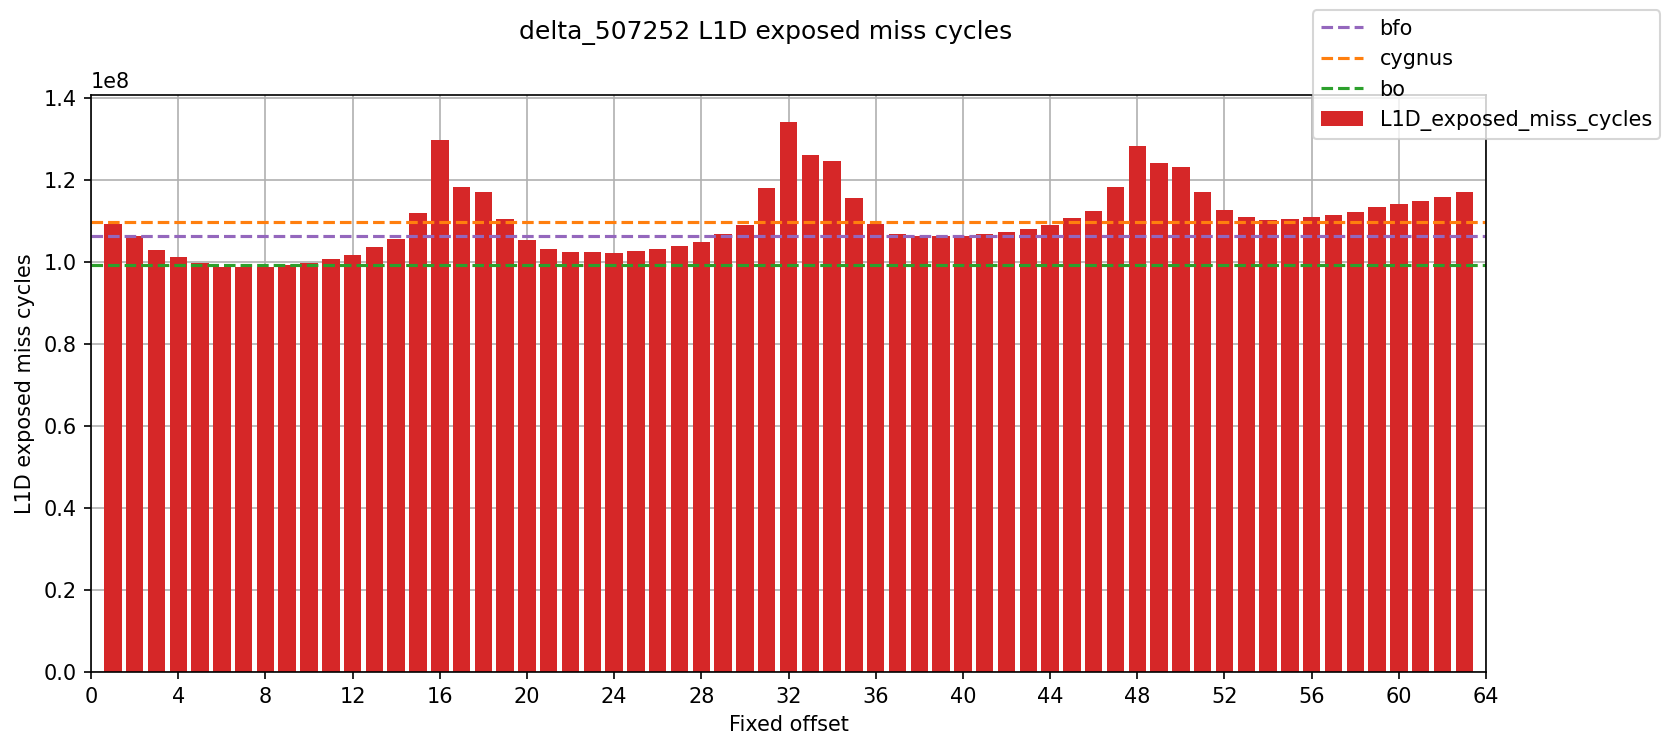

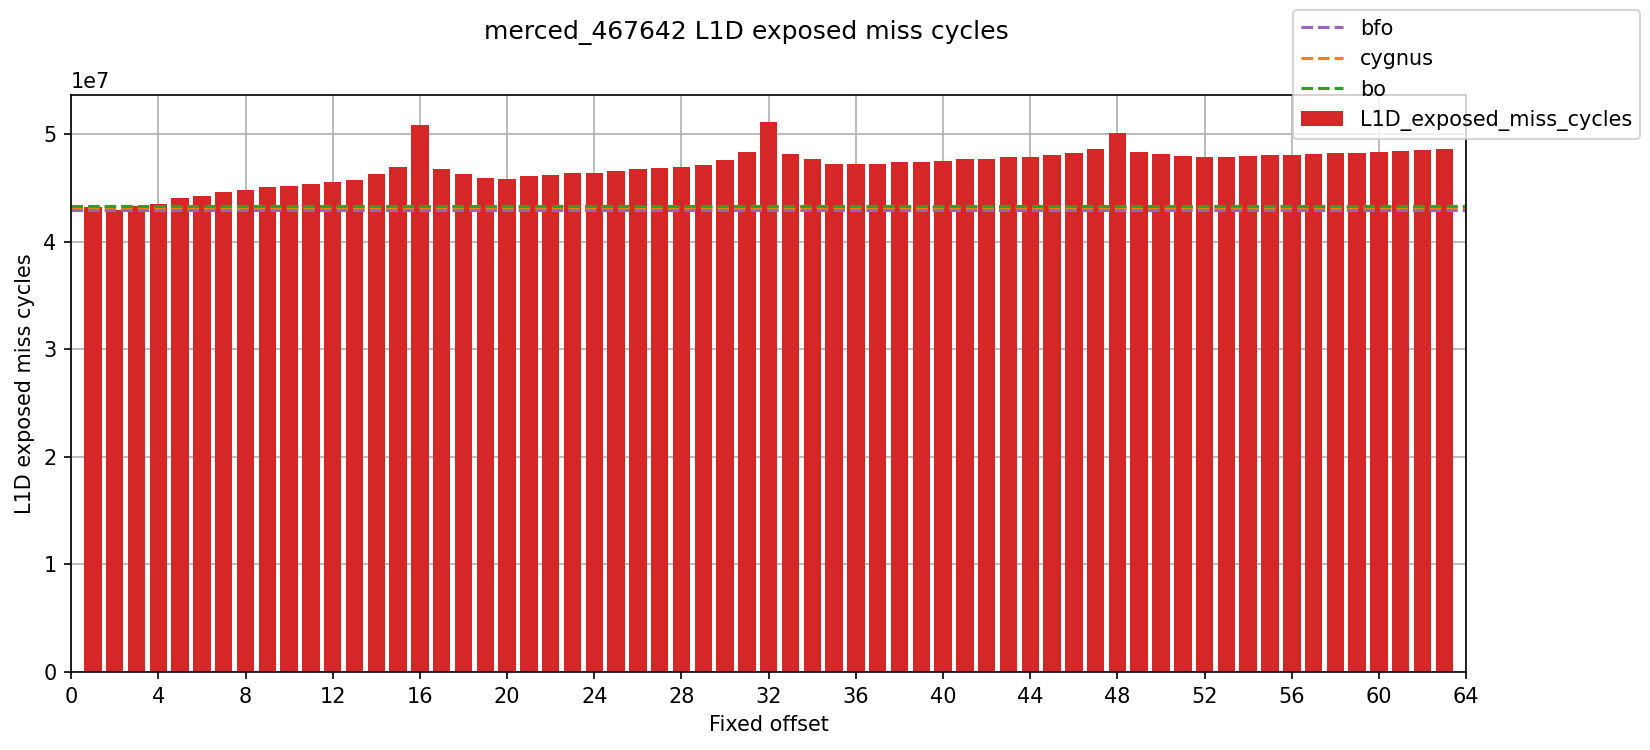

In [15]:
for trace in traces:
    plot_fixed_offsets(dfs, trace, ['L1D_exposed_miss_cycles'], title='L1D exposed miss cycles',
                       dpi=dpi, figsize=(12, 5), baselines=baselines)

### Unique exposed miss cycles

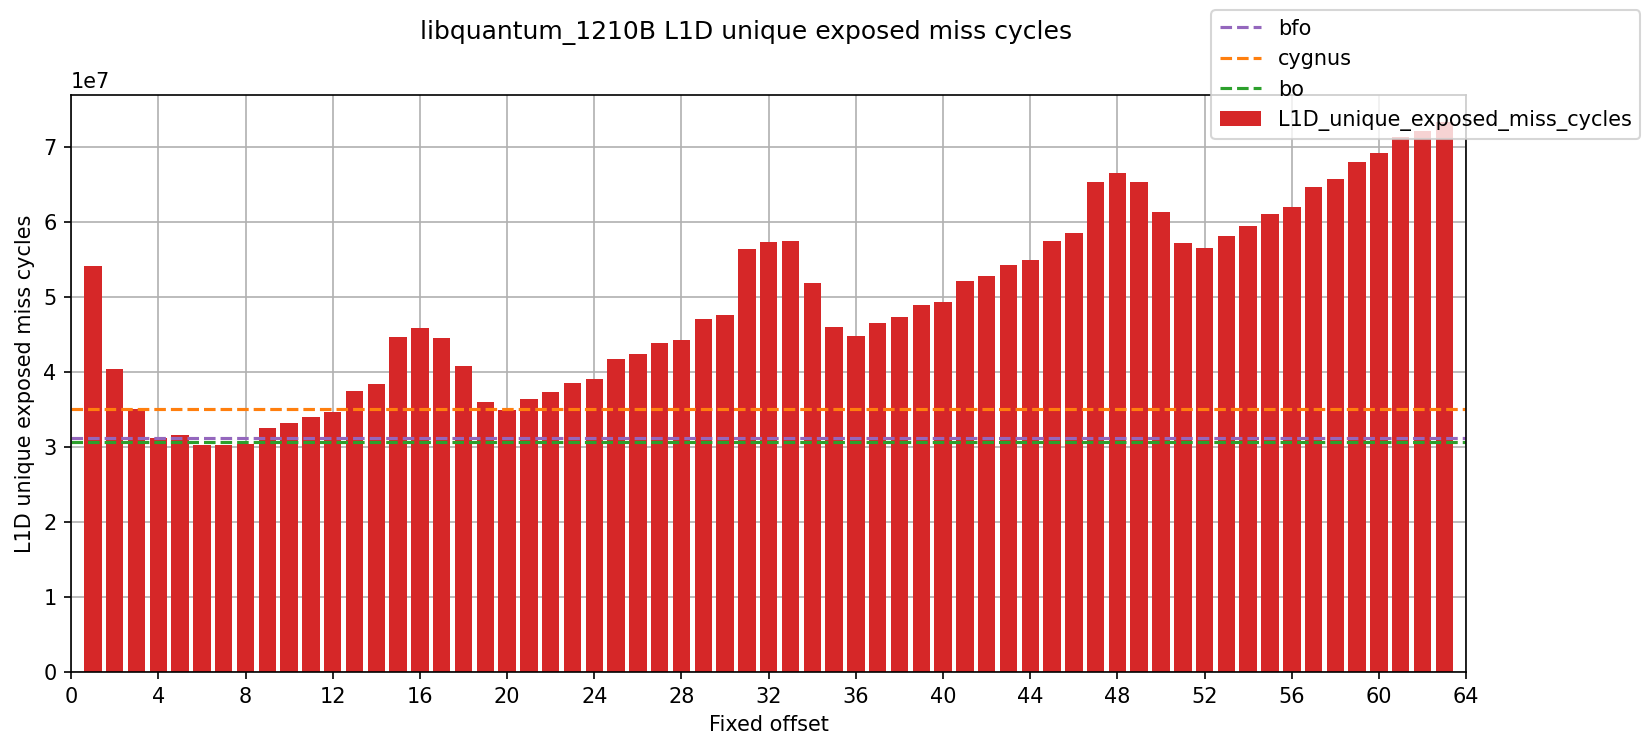

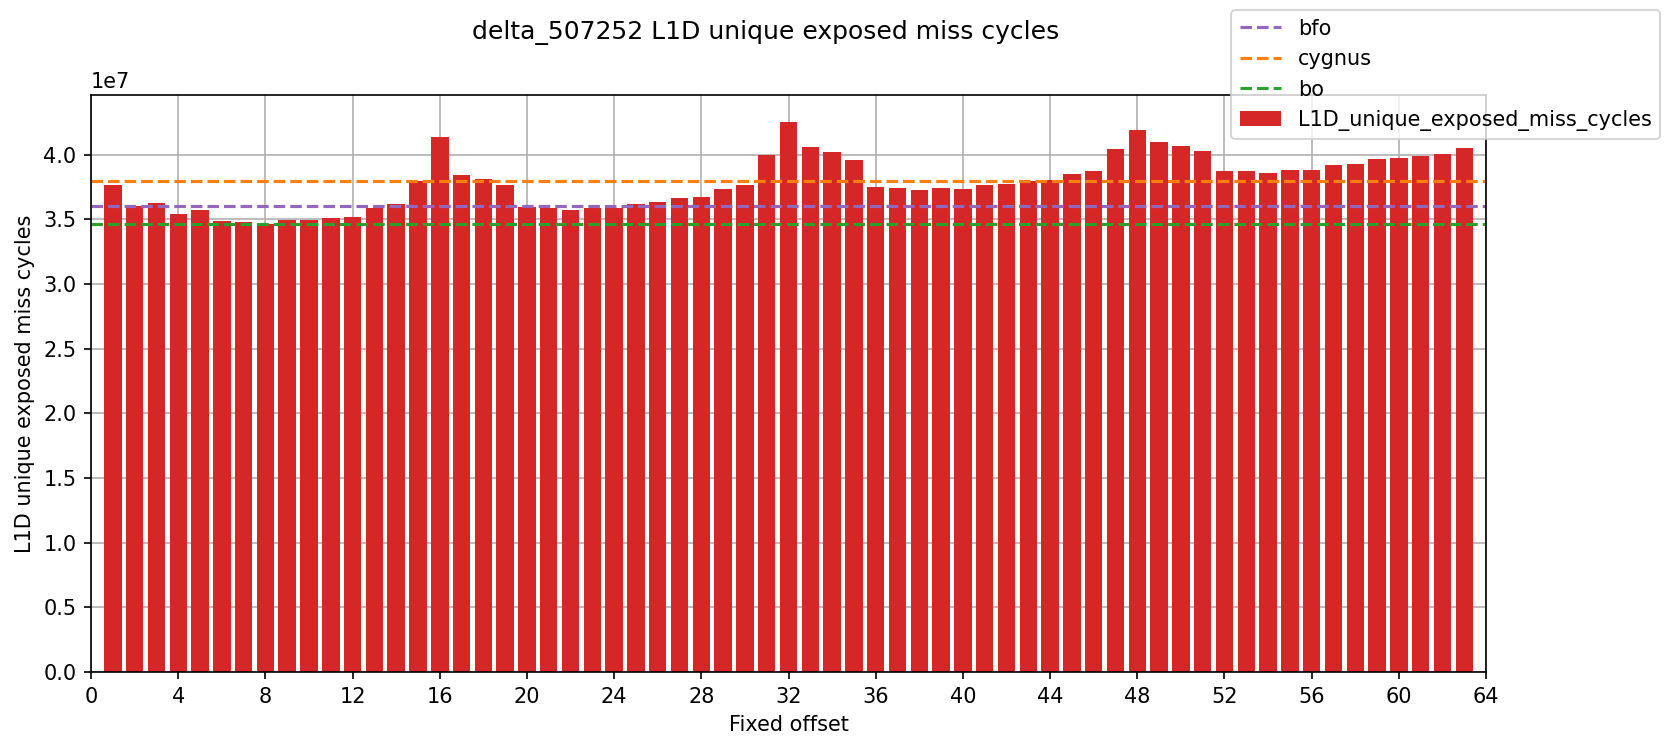

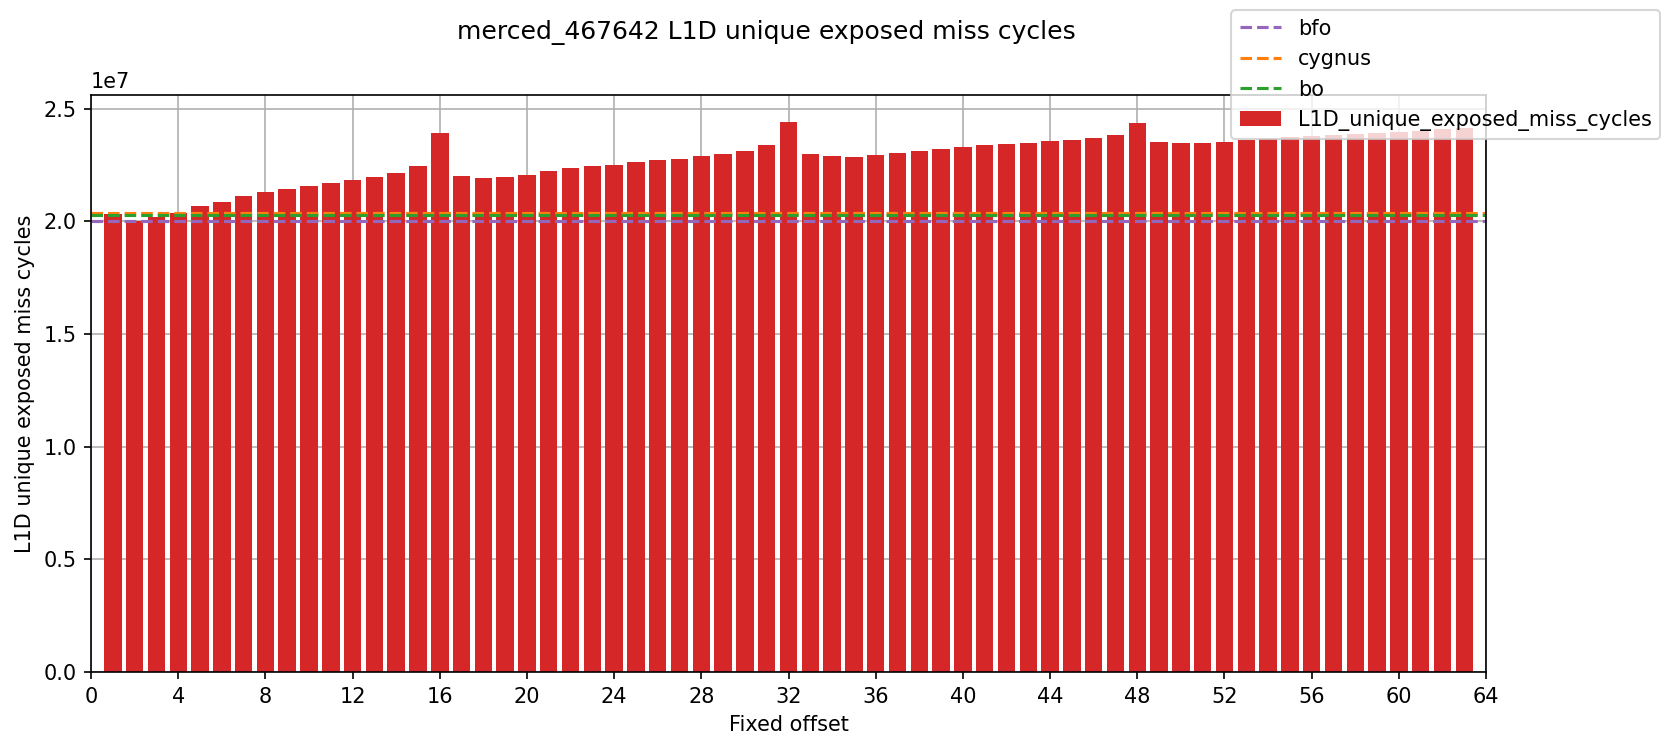

In [16]:
for trace in traces:
    plot_fixed_offsets(dfs, trace, ['L1D_unique_exposed_miss_cycles'], title='L1D unique exposed miss cycles',
                       dpi=dpi, figsize=(12, 5), baselines=baselines)

# Tables

In [36]:
def table_metric(prefetchers_df, trace, metrics=['ipc_improvement']):
    data = defaultdict(list)
    for pf, df in prefetchers_df.items():
        data['prefetcher'].append(pf)
        for metric in metrics:
            val = df[df.cpu0_full_trace == trace][metric]
            val = val.iloc[0].item() if len(val) > 0 else np.nan
            data[metric].append(val)

    df = pd.DataFrame(data).set_index('prefetcher')
    pd.set_option('display.max_rows', None)
    display(df)

In [30]:
table_df = {
    'bfo': baselines['bfo'],
    'bo': baselines['bo'],
    'cygnus': baselines['cygnus'],
}

## CPU

In [37]:
for trace in traces:
    print(f'\n===\n===== {trace} =====\n===')
    table_metric(table_df, trace, ['ipc_improvement', 'total_stall_cycles', 'total_stall_instructions', 'L1D_exposed_miss_cycles', 'L1D_unique_exposed_miss_cycles'])


===
===== libquantum_1210B =====
===


,ipc_improvement,total_stall_cycles,total_stall_instructions,L1D_exposed_miss_cycles,L1D_unique_exposed_miss_cycles
prefetcher,,,,,
bfo,98.831611,33384577,8558116,66315562,31184872
bo,94.844144,34342303,8893617,50241668,30637681
cygnus,75.669319,39266160,9412696,60744288,35048229



===
===== delta_507252 =====
===


,ipc_improvement,total_stall_cycles,total_stall_instructions,L1D_exposed_miss_cycles,L1D_unique_exposed_miss_cycles
prefetcher,,,,,
bfo,13.305124,53789761,5599532,106343850,36031206
bo,12.492783,54248303,5588683,99251421,34610588
cygnus,9.280266,56153669,5616397,109948110,37932776



===
===== merced_467642 =====
===


,ipc_improvement,total_stall_cycles,total_stall_instructions,L1D_exposed_miss_cycles,L1D_unique_exposed_miss_cycles
prefetcher,,,,,
bfo,18.696818,50347830,7167585,42911492,20008530
bo,17.073581,51165143,7135957,43261357,20290422
cygnus,15.661680,51924577,7170867,43195696,20358512


## L2

In [32]:
for trace in traces:
    print(f'\n===\n===== {trace} =====\n===')
    table_metric(table_df, trace, [
        'L2C_hit_rate', 'L2C_exposed_miss_cycles', 
        'L2C_unique_exposed_miss_cycles', 'L2C_coverage', 'L2C_late_coverage', 
        'L2C_accuracy', 'L2C_timely_accuracy'])


===
===== libquantum_1210B =====
===


,L2C_hit_rate,L2C_exposed_miss_cycles,L2C_unique_exposed_miss_cycles,L2C_coverage,L2C_late_coverage,L2C_accuracy,L2C_timely_accuracy
prefetcher,,,,,,,
bfo,0.389993,49740076,23718156,38.999261,93.747950,99.998301,41.599395
bo,0.744629,33669533,17204267,74.462884,90.388424,99.998318,82.379544
cygnus,0.795879,44172844,20957868,79.587875,80.868597,99.998567,98.414882



===
===== delta_507252 =====
===


,L2C_hit_rate,L2C_exposed_miss_cycles,L2C_unique_exposed_miss_cycles,L2C_coverage,L2C_late_coverage,L2C_accuracy,L2C_timely_accuracy
prefetcher,,,,,,,
bfo,0.514472,97561570,35262591,16.198107,40.214243,70.822725,43.122991
bo,0.551547,92015564,34230552,22.631774,35.357333,62.163427,46.796091
cygnus,0.477603,101802910,37701802,7.575766,26.485499,59.650345,41.247453



===
===== merced_467642 =====
===


,L2C_hit_rate,L2C_exposed_miss_cycles,L2C_unique_exposed_miss_cycles,L2C_coverage,L2C_late_coverage,L2C_accuracy,L2C_timely_accuracy
prefetcher,,,,,,,
bfo,0.570470,42764369,21729666,27.395292,37.911285,59.536555,53.375087
bo,0.568859,43782450,22686813,26.740895,33.977547,53.105788,48.980605
cygnus,0.540988,44539247,23319333,21.085168,37.023040,56.006103,48.751051


## L1D

In [33]:
for trace in traces:
    print(f'\n===\n===== {trace} =====\n===')
    table_metric(table_df, trace, [
        'L1D_hit_rate', 'L1D_exposed_miss_cycles', 
        'L1D_unique_exposed_miss_cycles'])


===
===== libquantum_1210B =====
===


,L1D_hit_rate,L1D_exposed_miss_cycles,L1D_unique_exposed_miss_cycles
prefetcher,,,
bfo,0.391682,66315562,31184872
bo,0.399613,50241668,30637681
cygnus,0.387471,60744288,35048229



===
===== delta_507252 =====
===


,L1D_hit_rate,L1D_exposed_miss_cycles,L1D_unique_exposed_miss_cycles
prefetcher,,,
bfo,0.904318,106343850,36031206
bo,0.904966,99251421,34610588
cygnus,0.904146,109948110,37932776



===
===== merced_467642 =====
===


,L1D_hit_rate,L1D_exposed_miss_cycles,L1D_unique_exposed_miss_cycles
prefetcher,,,
bfo,0.947568,42911492,20008530
bo,0.947033,43261357,20290422
cygnus,0.947028,43195696,20358512
